In [1]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import csv
from itertools import combinations, starmap
from matplotlib import pyplot as plt
import seaborn as sns
from upsetplot import generate_counts, plot, UpSet


def fasta_reader(file):
    '''Converts .fasta to a pandas dataframe with accession as index
    and sequence in a column 'sequence'
    '''
    fasta_df = pd.read_csv(file, sep='>', lineterminator='>', header=None)
    fasta_df[['Accession', 'Sequence']] = fasta_df[0].str.split('\n', 1, \
                                        expand=True)
    fasta_df['Accession'] = fasta_df['Accession']
    fasta_df['Sequence'] = fasta_df['Sequence'].replace('\n', '', regex=True).\
                            astype(str).str.upper().replace('U', 'C')
    total_seq = fasta_df.shape[0]
    fasta_df.drop(0, axis=1, inplace=True)
    fasta_df = fasta_df[fasta_df.Sequence != '']
    fasta_df = fasta_df[fasta_df.Sequence != 'NONE']
    final_df = fasta_df.dropna()
    remained_seq = final_df.shape[0]
    if total_seq != remained_seq:
        print("{} sequences were removed due to inconsistencies in"
                      "provided file.".format(total_seq-remained_seq))
    return final_df


def overlap_coefficient(list1, list2):
    intersection = len(set(list1).intersection(list2))
    minset = np.min([len(set(list1)), len(set(list2))]) 
    return intersection / minset

#### Process PPI datasets

##### BIOGRID

In [2]:
biogrid = pd.read_csv('../ref/biogrid/BIOGRID-MV-Physical-4.4.204.mitab.txt.gz', sep='\t')
biogrid = biogrid[(biogrid['Alt IDs Interactor A'].str.contains('uniprot/swiss-prot:')) & (biogrid['Alt IDs Interactor B'].str.contains('uniprot/swiss-prot:'))]
biogrid['ProteinA'] = biogrid['Alt IDs Interactor A'].str.split('|')
biogrid['ProteinB'] = biogrid['Alt IDs Interactor B'].str.split('|')

biogrid = biogrid.explode('ProteinA')
biogrid = biogrid[(biogrid['ProteinA'].str.contains('uniprot/swiss-prot:'))]
biogrid = biogrid.explode('ProteinB')
biogrid = biogrid[(biogrid['ProteinA'].str.contains('uniprot/swiss-prot:')) & (biogrid['ProteinB'].str.contains('uniprot/swiss-prot:'))]
biogrid['ProteinA'] = biogrid['ProteinA'].str.replace('uniprot/swiss-prot:','')
biogrid['ProteinB'] = biogrid['ProteinB'].str.replace('uniprot/swiss-prot:','')

biogrid['BIOGRID'] = biogrid[['#ID Interactor A','ID Interactor B']].values.tolist()
biogrid['BIOGRID'] = biogrid.BIOGRID.apply(lambda x: '_'.join(sorted(x)))
biogrid['Pairs'] = biogrid[['ProteinA','ProteinB']].values.tolist()
biogrid['Pairs'] = biogrid.Pairs.apply(lambda x: '_'.join(sorted(x)))

biogrid['Taxid Interactor A'] = biogrid['Taxid Interactor A'].str.replace('taxid:','')
biogrid['Taxid Interactor A'] = biogrid['Taxid Interactor A'].astype(int)
biogrid['Taxid Interactor B'] = biogrid['Taxid Interactor B'].str.replace('taxid:','')
biogrid['Taxid Interactor B'] = biogrid['Taxid Interactor B'].astype(int)
biogrid['Taxsum'] = biogrid[['Taxid Interactor A','Taxid Interactor B']].values.tolist()
biogrid['Taxsum'] = biogrid['Taxsum'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
biogrid[['BIOGRID','Pairs','Taxsum']].to_pickle('../data/biogrid.pkl.gz')

<AxesSubplot:>

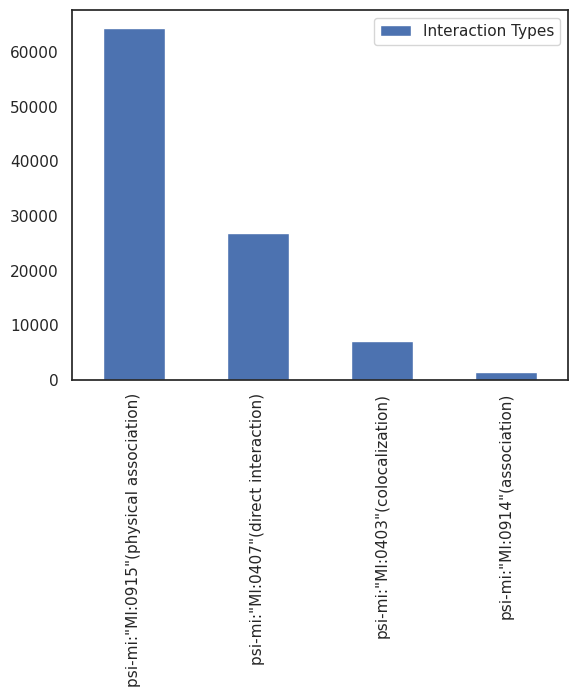

In [3]:
biogridp = biogrid[(biogrid['Interaction Types']=='MI:0915(physical association)')]
biogrida = biogrid[(biogrid['Interaction Types']=='MI:0914(association)')]
# biogridd = biogrid[(biogrid['Interaction Types']=='MI:0407(direct interaction)')]
biogrido = biogrid[(biogrid['Interaction Types']!='MI:0915(physical association)') & (biogrid['Interaction Types']!='MI:0914(association)')]
biogrid = pd.concat([biogrido,biogridp,biogrida]).drop_duplicates('Pairs')

sns.set(style='white')
pd.DataFrame(biogrid['Interaction Types'].value_counts()).plot.bar()

#### DIP

In [4]:
dip_dfs = []
for i in glob('../ref/dip/*.txt.gz'):
    try:
        dip = pd.read_csv(i, sep='\t').reset_index()
        dip = dip.drop(['Processing Status','Unnamed: 16'], axis=1)
        dip.columns = list(dip.columns[1:16]) + ['Processing Status']
        dip_dfs.append(dip)
    except Exception:
        print(i)
        pass
dip = pd.concat(dip_dfs)
dip = dip[(dip['ID interactor A'].str.contains('uniprotkb:')) & (dip['ID interactor B'].str.contains('uniprotkb:'))].copy()
dip['ProteinA'] = dip['ID interactor A'].str.split('|')
dip['ProteinB'] = dip['ID interactor B'].str.split('|')
dip = dip.explode('ProteinA')
dip = dip[(dip['ProteinA'].str.contains('uniprotkb:'))].copy()
dip = dip.explode('ProteinB')
dip = dip[(dip['ProteinB'].str.contains('uniprotkb:'))].copy()
dip['ProteinA'] = dip['ProteinA'].str.replace('uniprotkb:','')
dip['ProteinB'] = dip['ProteinB'].str.replace('uniprotkb:','')

dip['DIP'] = dip[['ID interactor A','ID interactor B']].values.tolist()
dip['DIP'] = dip.DIP.apply(lambda x: '_'.join(sorted(x)))
dip['Pairs'] = dip[['ProteinA','ProteinB']].values.tolist()
dip['Pairs'] = dip.Pairs.apply(lambda x: '_'.join(sorted(x)))

dip['Taxid interactor A'] = dip['Taxid interactor A'].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
dip['Taxid interactor A'] = dip['Taxid interactor A'].astype(int)
dip['Taxid interactor B'] = dip['Taxid interactor B'].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
dip['Taxid interactor B'] = dip['Taxid interactor B'].astype(int)
dip['Taxsum'] = dip[['Taxid interactor A','Taxid interactor B']].values.tolist()
dip['Taxsum'] = dip['Taxsum'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
dip[['DIP','Pairs','Taxsum']].to_pickle('../data/dip.pkl.gz')

<AxesSubplot:>

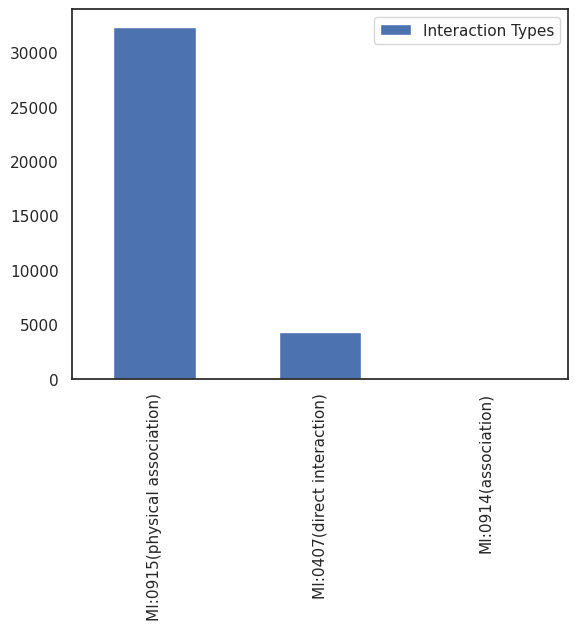

In [5]:
dip['Interaction Types'] = dip['Interaction type(s)'].str.split('|')
dip = dip.explode('Interaction Types').drop_duplicates()
dipp = dip[(dip['Interaction Types'].str.contains('MI:0915'))]
dipa = dip[(dip['Interaction Types'].str.contains('MI:0914'))]
dipd = dip[(dip['Interaction Types'].str.contains('MI:0407'))]
dipo = dip[(~dip['Interaction Types'].str.contains('MI:0915')) & (~dip['Interaction Types'].str.contains('MI:0914') & (dip['Interaction Types'].str.contains('MI:0407')))]
dip = pd.concat([dipo,dipd,dipp,dipa]).drop_duplicates('Pairs')

sns.set(style='white')
pd.DataFrame(dip['Interaction Types'].value_counts()).plot.bar()

#### IntAct

In [6]:
intact = pd.read_csv('../ref/intact/intact.txt.gz', sep='\t')
intact = intact[(intact['#ID(s) interactor A'].str.contains('uniprotkb:')) & (intact['ID(s) interactor B'].str.contains('uniprotkb:'))]
intact['ProteinA'] = intact['#ID(s) interactor A'].str.replace('uniprotkb:','')
intact['ProteinB'] = intact['ID(s) interactor B'].str.replace('uniprotkb:','')

intact['IntAct'] = intact[['#ID(s) interactor A','ID(s) interactor B']].values.tolist()
intact['IntAct'] = intact.IntAct.apply(lambda x: '_'.join(sorted(x)))
intact['Pairs'] = intact[['ProteinA','ProteinB']].values.tolist()
intact['Pairs'] = intact.Pairs.apply(lambda x: '_'.join(sorted(x)))

intact['Taxid interactor A'] = intact['Taxid interactor A'].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
intact['Taxid interactor A'] = intact['Taxid interactor A'].astype(int)
intact['Taxid interactor B'] = intact['Taxid interactor B'].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
intact['Taxid interactor B'] = intact['Taxid interactor B'].astype(int)
intact['Taxsum'] = intact[['Taxid interactor A','Taxid interactor B']].values.tolist()
intact['Taxsum'] = intact['Taxsum'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
intact[['IntAct','Pairs','Taxsum']].to_pickle('../data/intact.pkl.gz')

<AxesSubplot:>

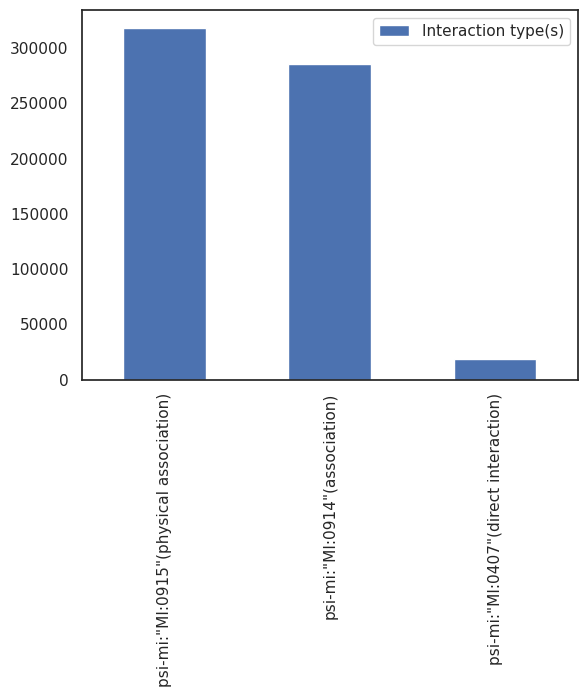

In [7]:
intactp = intact[(intact['Interaction type(s)'].str.contains('MI:0915'))]
intacta = intact[(intact['Interaction type(s)'].str.contains('MI:0914'))]
intactd = intact[(intact['Interaction type(s)'].str.contains('MI:0407'))]
intacto = intact[(~intact['Interaction type(s)'].str.contains('MI:0915')) & (~intact['Interaction type(s)'].str.contains('MI:0914') & (intact['Interaction type(s)'].str.contains('MI:0407')))]
intact = pd.concat([intacto,intactd,intactp,intacta]).drop_duplicates('Pairs')

sns.set(style='white')
pd.DataFrame(intact['Interaction type(s)'].value_counts()).plot.bar()

#### mentha

In [8]:
mentha = pd.read_csv('../ref/mentha/2021-12-20_MITAB-2.5.zip', sep='\t', header=None)
mentha = mentha[(mentha[0].str.contains('uniprotkb:')) & (mentha[1].str.contains('uniprotkb:'))]
mentha['ProteinA'] = mentha[0].str.replace('uniprotkb:','')
mentha['ProteinB'] = mentha[1].str.replace('uniprotkb:','')

mentha['mentha'] = mentha[[0,1]].values.tolist()
mentha['mentha'] = mentha.mentha.apply(lambda x: '_'.join(sorted(x)))
mentha['Pairs'] = mentha[['ProteinA','ProteinB']].values.tolist()
mentha['Pairs'] = mentha.Pairs.apply(lambda x: '_'.join(sorted(x)))

mentha[9] = mentha[9].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
mentha[9] = mentha[9].astype(int)
mentha[10] = mentha[10].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
mentha[10] = mentha[10].astype(int)
mentha['Taxsum'] = mentha[[9,10]].values.tolist()
mentha['Taxsum'] = mentha['Taxsum'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
mentha[['mentha','Pairs','Taxsum']].to_pickle('../data/mentha.pkl.gz')

<AxesSubplot:>

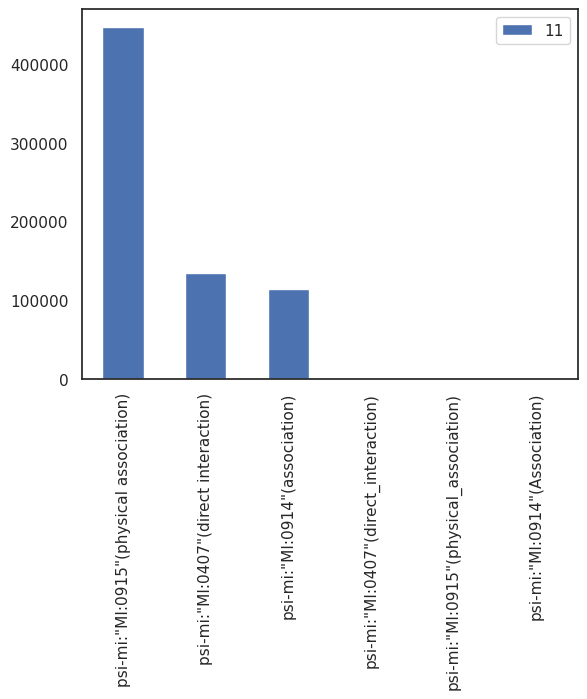

In [9]:
menthap = mentha[(mentha[11].str.contains('MI:0915'))]
menthaa = mentha[(mentha[11].str.contains('MI:0914'))]
menthad = mentha[(mentha[11].str.contains('MI:0407'))]
menthao = mentha[(~mentha[11].str.contains('MI:0915')) & (~mentha[11].str.contains('MI:0914') & (mentha[11].str.contains('MI:0407')))]
mentha = pd.concat([menthao,menthad,menthap,menthaa]).drop_duplicates('Pairs')

sns.set(style='white')
pd.DataFrame(mentha[11].value_counts()).plot.bar()

#### MINT

In [10]:
mint = pd.read_csv('../ref/mint/mint.txt.gz', sep='\t', header=None)
mint = mint[(mint[0].str.contains('uniprotkb:')) & (mint[1].str.contains('uniprotkb:'))]
mint['ProteinA'] = mint[0].str.replace('uniprotkb:','')
mint['ProteinB'] = mint[1].str.replace('uniprotkb:','')

mint['MINT'] = mint[[0,1]].values.tolist()
mint['MINT'] = mint.MINT.apply(lambda x: '_'.join(sorted(x)))
mint['Pairs'] = mint[['ProteinA','ProteinB']].values.tolist()
mint['Pairs'] = mint.Pairs.apply(lambda x: '_'.join(sorted(x)))

mint[9] = mint[9].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
mint[9] = mint[9].astype(int)
mint[10] = mint[10].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
mint = mint[mint[10].apply(lambda x: x.isdigit())]
mint[10] = mint[10].astype(int)
mint['Taxsum'] = mint[[9,10]].values.tolist()
mint['Taxsum'] = mint['Taxsum'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
mint[['MINT','Pairs','Taxsum']].to_pickle('../data/mint.pkl.gz')

<AxesSubplot:>

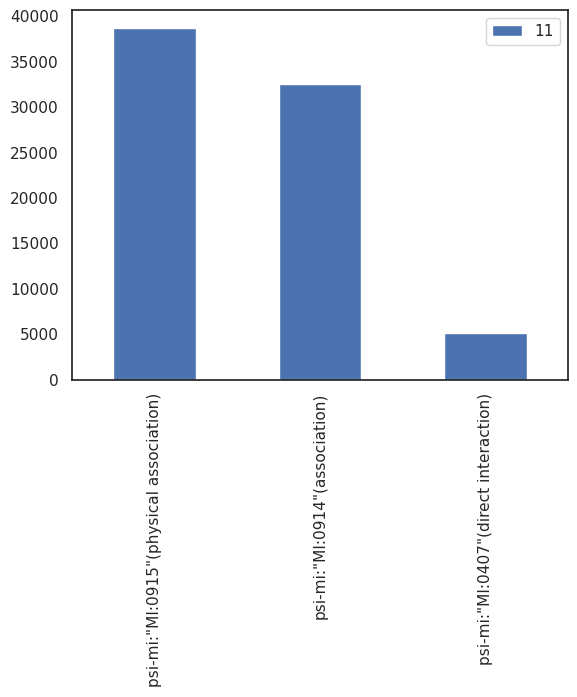

In [11]:
mintp = mint[(mint[11].str.contains('MI:0915'))]
minta = mint[(mint[11].str.contains('MI:0914'))]
mintd = mint[(mint[11].str.contains('MI:0407'))]
minto = mint[(~mint[11].str.contains('MI:0915')) & (~mint[11].str.contains('MI:0914') & (mint[11].str.contains('MI:0407')))]
mint = pd.concat([minto,mintd,mintp,minta]).drop_duplicates('Pairs')

sns.set(style='white')
pd.DataFrame(mint[11].value_counts()).plot.bar()

#### signor Jan2022 release

In [2]:
signor = pd.read_csv('../ref/signor/Jan2022_release.txt.gz', sep='\t')
signor = signor[(signor.DATABASEA=='UNIPROT') & (signor.DATABASEB=='UNIPROT')].copy()
signor['Pairs'] = signor[['IDA','IDB']].values.tolist()
signor['Pairs'] = signor.Pairs.apply(lambda x: '_'.join(sorted(x)))
signor['signor'] = signor.Pairs
signor['TAX_ID'] = signor.TAX_ID.fillna(-1).astype(int)
signor['Taxsum'] = str(signor.TAX_ID) + '_' + str(signor.TAX_ID)
signor[['signor','Pairs','Taxsum']].to_pickle('../data/signor.pkl.gz')

#### BioPlex 3.0

In [2]:
# BioPlex positives
t = pd.read_csv('../ref/bioplex/BioPlex_293T_Network_10K_Dec_2019.tsv', sep='\t')[['UniprotA','UniprotB']]
h = pd.read_csv('../ref/bioplex/BioPlex_HCT116_Network_5.5K_Dec_2019.tsv', sep='\t')[['UniprotA','UniprotB']]
th = pd.concat([t,h])
th = th[th.duplicated()]
th = th[th.UniprotA!='UNKNOWN']
th['Interaction'] = 1

# BioPlex negatives
ut = pd.read_csv('../ref/bioplex/BioPlex_BaitPreyPairs_noFilters_293T_10K_Dec_2019.tsv', sep='\t')
uh = pd.read_csv('../ref/bioplex/BioPlex_BaitPreyPairs_noFilters_HCT116_5.5K_Dec_2019.tsv', sep='\t')
uth = pd.concat([ut[ut.pInt<0.1][['bait_geneid','db_protein_id']],uh[uh.pInt<0.1][['bait_geneid','db_protein_id']]])
uth = uth[uth.duplicated()]
uth['UniprotB'] = uth.db_protein_id.str.split('|').apply(lambda x: x[1])
uth['Interaction'] = 0
th.shape, uth.shape

((14947, 3), (1714911, 4))

In [3]:
','.join([str(i) for i in uth.bait_geneid.unique()])

'88455,286499,2205,29960,8939,50614,3487,91464,55554,151888,441493,116135,4153,4239,326625,113746,10336,10954,51050,51588,80007,113791,5645,5686,387496,8625,51119,729238,139886,339448,6716,90316,284486,113277,7128,7138,118424,926,26097,50856,1633,27123,112399,93,23097,115,30850,64946,55166,29883,25839,4253,8165,23113,26094,64794,1659,1993,84908,122786,51608,160428,29997,3014,3320,3312,10525,64376,218,7850,3608,23210,57648,8874,3958,57226,4163,26747,54830,10956,390748,5300,5351,5501,5522,79065,5698,7803,79863,6229,23378,9733,51097,22872,7095,9869,10479,55133,573,6744,9482,55959,6838,148281,54732,9528,7185,128408,11338,9217,22884,55884,7508,91419,25844,51538,79736,150383,7203,11140,55038,8621,345651,10898,208,1469,58190,192668,79039,8525,200895,90957,27185,2202,57669,262,114625,54461,2249,246176,60313,3052,3065,3010,255626,431705,3614,129285,83746,65108,4204,10200,4841,55505,54940,114879,64881,567,56140,56132,56110,56983,5427,11232,171568,4660,3275,132720,10981,26953,5922,9904,23029,6194

In [4]:
uth_geneid = pd.read_csv('../ref/uniprot/idmapping_2023_10_19.tsv.gz', sep='\t')
uth_geneid = uth_geneid[~uth_geneid.Sequence.isna()]
uth_geneid.rename(columns={'From':'bait_geneid','Entry':'UniprotA'}, inplace=True)
uth_geneid = uth_geneid.sort_values(['bait_geneid','Reviewed']).drop_duplicates('bait_geneid')

uth['bait_geneid'] = uth.bait_geneid.astype(int)
uth_geneid['bait_geneid'] = uth_geneid.bait_geneid.astype(int)

uth = pd.merge(uth, uth_geneid, on='bait_geneid')[['UniprotA','UniprotB','Interaction']]
pd.concat([th,uth]).to_pickle('../data/bioplex_interactions.pkl.gz')

In [5]:
th['Pairs'] = th[['UniprotA','UniprotB']].values.tolist()
th['Pairs'] = th.Pairs.apply(lambda x: '_'.join(sorted([x[0], x[1]])))
th['Taxsum'] = '9606_9606'
th['BioPlex'] = th.Pairs
th[['BioPlex','Pairs','Taxsum']].to_pickle('../data/bioplex.pkl.gz')

#### STRING

In [14]:
from pandarallel import pandarallel
pandarallel.initialize()

string = pd.read_csv('../ref/string/protein.physical.links.full.exp.v11.5.txt.gz', sep='\s+')
aliases = pd.read_csv('../ref/string/protein.aliases.UniProt_AC.v11.5.txt.gz', sep='\t', header=None)
aliases.columns = ['#string_protein_id','alias','source']
string = pd.merge(pd.merge(string, aliases.rename(columns={'#string_protein_id':'protein1'}), on='protein1'),\
                  aliases.rename(columns={'#string_protein_id':'protein2'}), on='protein2')

string['STRING'] = string[['protein1','protein2']].values.tolist()
string['STRING'] = string.STRING.parallel_apply(lambda x: '_'.join(sorted(x)))
string['Pairs'] = string[['alias_x','alias_y']].values.tolist()
string['Pairs'] = string.Pairs.parallel_apply(lambda x: '_'.join(sorted(x)))

string[9] = string.protein1.str.split('\.').parallel_apply(lambda x: x[0])
string[9] = string[9].astype(int)
string[10] = string.protein2.str.split('\.').parallel_apply(lambda x: x[0])
string[10] = string[10].astype(int)
string['Taxsum'] = string[[9,10]].values.tolist()
string['Taxsum'] = string['Taxsum'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
string[['STRING','Pairs','Taxsum']].to_pickle('../data/string.pkl.gz')

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Map all UniProt IDs to UniProt Primary IDs through UniProt ID mapping web service

In [2]:
biogrid = pd.read_pickle('../data/biogrid.pkl.gz')
dip = pd.read_pickle('../data/dip.pkl.gz')
intact = pd.read_pickle('../data/intact.pkl.gz')
mentha = pd.read_pickle('../data/mentha.pkl.gz')
mint = pd.read_pickle('../data/mint.pkl.gz')
signor = pd.read_pickle('../data/signor.pkl.gz')
bioplex = pd.read_pickle('../data/bioplex.pkl.gz')
string = pd.read_pickle('../data/string.pkl.gz')

biogrid['ProteinA'] = biogrid.Pairs.str.split('_').apply(lambda x: x[0])
biogrid['ProteinB'] = biogrid.Pairs.str.split('_').apply(lambda x: x[1])

dip['ProteinA'] = dip.Pairs.str.split('_').apply(lambda x: x[0])
dip['ProteinB'] = dip.Pairs.str.split('_').apply(lambda x: x[1])

intact['ProteinA'] = intact.Pairs.str.split('_').apply(lambda x: x[0])
intact['ProteinB'] = intact.Pairs.str.split('_').apply(lambda x: x[1])

mentha['ProteinA'] = mentha.Pairs.str.split('_').apply(lambda x: x[0])
mentha['ProteinB'] = mentha.Pairs.str.split('_').apply(lambda x: x[1])

mint['ProteinA'] = mint.Pairs.str.split('_').apply(lambda x: x[0])
mint['ProteinB'] = mint.Pairs.str.split('_').apply(lambda x: x[1])

signor['ProteinA'] = signor.Pairs.str.split('_').apply(lambda x: x[0])
signor['ProteinB'] = signor.Pairs.str.split('_').apply(lambda x: x[1])

bioplex['ProteinA'] = bioplex.Pairs.str.split('_').apply(lambda x: x[0])
bioplex['ProteinB'] = bioplex.Pairs.str.split('_').apply(lambda x: x[1])

string['ProteinA'] = string.Pairs.str.split('_').apply(lambda x: x[0])
string['ProteinB'] = string.Pairs.str.split('_').apply(lambda x: x[1])

In [3]:
c = pd.concat([biogrid,dip,intact,mentha,mint,signor,bioplex,string])
uniprot_ids = set(c.ProteinA.tolist() + c.ProteinB.tolist())

In [4]:
','.join(list(uniprot_ids)[:99999])

'Q13839,Q6P7E9,Q92331,O70201,F4JV48,Q7YSR2,Q109P5,P56006,D6VQW1,P19366,Q2M6K7,O60263,Q3TAC7,Q8NBP0-2,Q27232,Q66L72,Q8S403,Q9M3A8,Q9SGY2,A0A2R9AIB4,P47869,Q9SKH9,Q8N8Q4,F8VYL7,Q2WF71,Q96M67,A2A683,Q9UAV5,B7AA46,Q6P1G7,Q8RVQ6,P45569,P83050,A0A384AAG2,Q92318,Q8II71,A2AJA3,P59022,Q6GSG7,O95627,Q9D083,Q9FRS9,Q62621,O22823,Q3MIL2,Q3UMP0,P76907,Q86LS0,O43707,Q05CS4,P42346,Q9BR98,Q70Q87,Q5SS28,Q9VTE9,B4DTQ7,Q6ZUR5,P61823,Q5TAI8,D6VW21,Q9ZUU0,P72030,P22256,Q8BKI0,Q9ZQ38,Q9DBB5,Q8VZ02,Q7Z7H3,Q9VJJ3,Q95SN7,O64646,Q8N9F7,Q9FJB8,Q8N1T2,Q9H9A2,A1L400,B0YJ88,O89041,O95613,Q9URW0,P99026,Q8CGY8,Q20271,P54819-2,B2RCT8,Q6GU33,Q59765,Q9SHP9,O82763,Q9U9Q1,Q22A77,P96706,P08913,Q9BTB2,A6NCP5,Q7Z5R5,A5YM54,Q76H80,A0A0D9QVK0,Q9SPG2,Q2LE81,Q8C906,Q72WL8,Q9XUU4,Q9TQC8,Q8ZPH0,O83193,Q6S545,Q78S06,Q9NRD4,Q9F0J8,P78329,Q37077,P38805,Q9R1M0,Q80Y81,P48664,O82660,B2R957,Q07979,P0DMW0,Q5T648,A0A287ATV8,Q9BSQ0,Q90635,Q8U1R4,Q8HWS7,Q50306,P15039,Q56W43,P78775,Q9W4J3,Q9ZQP0,Q8N1H5,Q9BZ29-5,Q9N580,P11612,Q9CSU9,P05023-1,B7

In [5]:
','.join(list(uniprot_ids)[99999:199999])

'A4D2C3,Q53SF7-2,Q96MX0,Q8NF50-2,C0LGI6,Q86UK6,B3KWB0,B4E2U9,Q3UGT2,Q9P213,Q9VMP9,P49661,P25037,Q8C7S8,Q5EBJ4,P14555,Q8TA99,Q31KK2,Q8N246,Q8LA96,Q8IV20,Q86U66,Q10356,Q96RK1,O81303,Q5I6Y4,Q7Z3H9,A8K924,Q9US13,P78544,Q9UAN4,Q5VSF3,Q3TAD8,Q9UFQ0,Q3TJB6,P32457,Q81W74,Q8IYM5,Q8N0Z4,E2GH25,Q96RW4,P40159,Q9VUH0,O95144,Q7CL81,A6NGP7,Q12175,D4AE59,Q9UBG0,Q08580,Q9BW19,P60521,H2L286,Q5JP55,Q81M47,E2R9T9,Q99249,Q20898,X5DNR8,Q80UN8,Q9UFY7,O70493,O43190,Q06BH2,B6RI03,Q6NNF2,P0A6C0,Q15813,Q13322-2,B3KN20,Q2M7C6,Q9W2B1,Q96H02,Q9SL15,D6VTX2,Q86XA6,Q53EQ0,Q6NU24,Q9USV1,Q9FUD3,D6W5K3,P78475,Q9Z0U1,Q53YK4,Q8NHS9,B9EHE9,O14681,Q9USE7,Q5T536,G8ZJ75,Q9XXI8,Q8TCG1-1,Q96J49,Q9X444,Q99K66,D3DNU2,Q9D955,D6RAK8,P11250,B2RBP9,Q3UZZ6,P59470,Q9VMP5,Q92359,O75299,A2ATY4,Q9BZD4,P06440,Q5KTT6,Q8NHM3,P26755,Q96II5,Q9UK04,P0A7I0,D3ZMX6,F4I3M3,A1Z9U3,Q5TZR4,Q86Y77,A8K002,Q6H1D8,B4DSM2,E9PGH8,Q9QX93,Q65Z93,Q84TI3,O76722,Q3TX76,E1P5Y0,O14868,Q9LIH5,Q0VF37,Q9VMS4,A2AJQ8,Q99794,Q9D681,Q8D0C8,Q8LPB4,O14962,Q8K0J0,Q9JKL5,Q68V

In [6]:
','.join(list(uniprot_ids)[199999:])

'Q4J9K8,Q06505,Q19262,D6VPP7,B4DT43,Q9NSG0,Q9UD08,E1P579,Q8TBE1,Q96C54,P05828,P76042,P21915,Q9F6L0,Q9BQC8,P02253,Q6ZST1,O42872,Q86WL9,Q7PA49,Q8TAV5,M9NEQ9,Q692E0,Q90593,Q640R1,T2GAT5,P0C0X0,Q586H0,Q14415,A3KMG3,Q2MC36,Q9NSH1,Q8BS82,Q6PEU6,A0A5P8YHK6,Q64373-1,A0A6L8P242,G0S7X9,Q3ZTT2,Q29025,Q2G298,Q542I4,Q5NBV8,Q9CYY6,Q9SA70,O94797,Q9BUY9,Q9TZA0,Q9VVE2,Q9BRZ6,Q9R1K5,Q93020,Q54FX1,B7Z9E2,E9PAG4,Q96Q93,Q80VI1,P12756,Q5JRF5,Q9D9B3,B4E114,Q5CZI4,O75897,Q96AJ4,Q9LSY1,B3KT03,A0A2U2H272,P36540,B2RTW0,Q19907,Q9UDM6,Q8N6U4,Q8W3L1,Q9VCL1,O35160,O35465,Q94AL0,Q5JSX9,Q7YQC6,Q0D2N2,Q6B322,Q5VV77,Q81YF4,Q3UI44,Q0VGC3,Q5T5P2-6,D6VWU8,Q8NBT9,Q8BSB4,Q63347,A2BFI7,Q80Z64-1,Q8BY46,A0AP51,Q9R1X2,Q6T264,Q9JII6,A2BE95,P09202,Q8TDQ1,P73006,B4DY24,Q3U201,Q5T0S8,Q66YK6,Q5QPM7,Q9Z1L5,Q10128,P75288,Q59EV6,Q8IAX6,B4E022,E9PGG4,Q4E2E0,Q9P2I8,Q9D0R4,Q5NV76,Q96KS2,D3ZSY3,Q9JJW7,B5BU45,Q57XX1,Q84JF5,P35462,P30843,D6VWU9,Q9Y637,Q55299,Q9SR78,Q5NH40,P48059,Q80VS9,Q9VM35,Q3V292,Q8WTU8,P02557,A8RCU3,Q9Y4W8,Q8WUA3,Q6GLD3,Q

In [7]:
file_path = '../ref/uniprot/'
idmapping = ['5a97f67abb0516f4172ff91185bc014e2a5350ab.gz','64443c4b0c26226c9c86c4f60d350e86d1620185.gz','idmapping_2024_03_14.tsv.gz']

u = []
for i in idmapping:
    u.append(pd.read_csv(file_path + i, sep='\t'))
    
u = pd.concat(u)
u['fasta'] = '>' + u.Entry + '\n' + u.Sequence
u = u[~u.fasta.isna()]
u.to_pickle('../data/idmapping.pkl.gz')
u.to_csv('../ref/uniprot/db.csv',index=False,header=False,quoting=csv.QUOTE_NONE,escapechar=' ')

u = u[['From', 'Entry','Organism','Organism (ID)','OrthoDB','PDBsum']]
u['OrthoDB'] = u.OrthoDB.fillna('OrthoDB_NaN;').str.split(';').apply(lambda x: x[0])
u['Organism'] = u.Organism.fillna('Organism_NaN')
u['Organism (ID)'] = u['Organism (ID)'].fillna(-1).astype(int)
u.shape, u.drop_duplicates('From').shape, u.drop_duplicates('Entry').shape

((256654, 6), (248660, 6), (120076, 6))

In [8]:
biogrid = pd.merge(pd.merge(biogrid, u.rename(columns={'From':'ProteinA'}), on='ProteinA'), 
                   u.rename(columns={'From':'ProteinB'}), on='ProteinB')
biogrid['Pairs'] = biogrid[['Entry_x','Entry_y']].values.tolist()
biogrid['Pairs'] = biogrid.Pairs.apply(lambda x: '_'.join(sorted(x)))
biogrid['OrthoDB pairs'] = biogrid[['OrthoDB_x','OrthoDB_y']].values.tolist()
biogrid['OrthoDB pairs'] = biogrid['OrthoDB pairs'].apply(lambda x: '_'.join(sorted(x)))
biogrid['PDB'] = biogrid[['PDBsum_x','PDBsum_y']].values.tolist()
biogrid['Organisms'] = biogrid[['Organism_x','Organism_y']].values.tolist()
biogrid['Organisms'] = biogrid['Organisms'].apply(lambda x: '__'.join(sorted(x)))
biogrid['Taxid pairs'] = biogrid[['Organism (ID)_x','Organism (ID)_y']].values.tolist()
biogrid['Taxid pairs'] = biogrid['Taxid pairs'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
biogrid.drop(['ProteinA','ProteinB','Entry_x','Entry_y','PDBsum_x','PDBsum_y','Organism_x','Organism_y','OrthoDB_x','OrthoDB_y','Organism (ID)_x','Organism (ID)_y'], inplace=True, axis=1)

dip = pd.merge(pd.merge(dip, u.rename(columns={'From':'ProteinA'}), on='ProteinA'), 
                   u.rename(columns={'From':'ProteinB'}), on='ProteinB')
dip['Pairs'] = dip[['Entry_x','Entry_y']].values.tolist()
dip['Pairs'] = dip.Pairs.apply(lambda x: '_'.join(sorted(x)))
dip['OrthoDB pairs'] = dip[['OrthoDB_x','OrthoDB_y']].values.tolist()
dip['OrthoDB pairs'] = dip['OrthoDB pairs'].apply(lambda x: '_'.join(sorted(x)))
dip['PDB'] = dip[['PDBsum_x','PDBsum_y']].values.tolist()
dip['Organisms'] = dip[['Organism_x','Organism_y']].values.tolist()
dip['Organisms'] = dip['Organisms'].apply(lambda x: '__'.join(sorted(x)))
dip['Taxid pairs'] = dip[['Organism (ID)_x','Organism (ID)_y']].values.tolist()
dip['Taxid pairs'] = dip['Taxid pairs'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
dip.drop(['ProteinA','ProteinB','Entry_x','Entry_y','PDBsum_x','PDBsum_y','Organism_x','Organism_y','OrthoDB_x','OrthoDB_y','Organism (ID)_x','Organism (ID)_y'], inplace=True, axis=1)

intact = pd.merge(pd.merge(intact, u.rename(columns={'From':'ProteinA'}), on='ProteinA'), 
                   u.rename(columns={'From':'ProteinB'}), on='ProteinB')
intact['Pairs'] = intact[['Entry_x','Entry_y']].values.tolist()
intact['Pairs'] = intact.Pairs.apply(lambda x: '_'.join(sorted(x)))
intact['OrthoDB pairs'] = intact[['OrthoDB_x','OrthoDB_y']].values.tolist()
intact['OrthoDB pairs'] = intact['OrthoDB pairs'].apply(lambda x: '_'.join(sorted(x)))
intact['PDB'] = intact[['PDBsum_x','PDBsum_y']].values.tolist()
intact['Organisms'] = intact[['Organism_x','Organism_y']].values.tolist()
intact['Organisms'] = intact['Organisms'].apply(lambda x: '__'.join(sorted(x)))
intact['Taxid pairs'] = intact[['Organism (ID)_x','Organism (ID)_y']].values.tolist()
intact['Taxid pairs'] = intact['Taxid pairs'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
intact.drop(['ProteinA','ProteinB','Entry_x','Entry_y','PDBsum_x','PDBsum_y','Organism_x','Organism_y','OrthoDB_x','OrthoDB_y','Organism (ID)_x','Organism (ID)_y'], inplace=True, axis=1)

mentha = pd.merge(pd.merge(mentha, u.rename(columns={'From':'ProteinA'}), on='ProteinA'), 
                   u.rename(columns={'From':'ProteinB'}), on='ProteinB')
mentha['Pairs'] = mentha[['Entry_x','Entry_y']].values.tolist()
mentha['Pairs'] = mentha.Pairs.apply(lambda x: '_'.join(sorted(x)))
mentha['OrthoDB pairs'] = mentha[['OrthoDB_x','OrthoDB_y']].values.tolist()
mentha['OrthoDB pairs'] = mentha['OrthoDB pairs'].apply(lambda x: '_'.join(sorted(x)))
mentha['PDB'] = mentha[['PDBsum_x','PDBsum_y']].values.tolist()
mentha['Organisms'] = mentha[['Organism_x','Organism_y']].values.tolist()
mentha['Organisms'] = mentha['Organisms'].apply(lambda x: '__'.join(sorted(x)))
mentha['Taxid pairs'] = mentha[['Organism (ID)_x','Organism (ID)_y']].values.tolist()
mentha['Taxid pairs'] = mentha['Taxid pairs'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
mentha.drop(['ProteinA','ProteinB','Entry_x','Entry_y','PDBsum_x','PDBsum_y','Organism_x','Organism_y','OrthoDB_x','OrthoDB_y','Organism (ID)_x','Organism (ID)_y'], inplace=True, axis=1)

mint = pd.merge(pd.merge(mint, u.rename(columns={'From':'ProteinA'}), on='ProteinA'), 
                   u.rename(columns={'From':'ProteinB'}), on='ProteinB')
mint['Pairs'] = mint[['Entry_x','Entry_y']].values.tolist()
mint['Pairs'] = mint.Pairs.apply(lambda x: '_'.join(sorted(x)))
mint['OrthoDB pairs'] = mint[['OrthoDB_x','OrthoDB_y']].values.tolist()
mint['OrthoDB pairs'] = mint['OrthoDB pairs'].apply(lambda x: '_'.join(sorted(x)))
mint['PDB'] = mint[['PDBsum_x','PDBsum_y']].values.tolist()
mint['Organisms'] = mint[['Organism_x','Organism_y']].values.tolist()
mint['Organisms'] = mint['Organisms'].apply(lambda x: '__'.join(sorted(x)))
mint['Taxid pairs'] = mint[['Organism (ID)_x','Organism (ID)_y']].values.tolist()
mint['Taxid pairs'] = mint['Taxid pairs'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
mint.drop(['ProteinA','ProteinB','Entry_x','Entry_y','PDBsum_x','PDBsum_y','Organism_x','Organism_y','OrthoDB_x','OrthoDB_y','Organism (ID)_x','Organism (ID)_y'], inplace=True, axis=1)

signor = pd.merge(pd.merge(signor, u.rename(columns={'From':'ProteinA'}), on='ProteinA'), 
                   u.rename(columns={'From':'ProteinB'}), on='ProteinB')
signor['Pairs'] = signor[['Entry_x','Entry_y']].values.tolist()
signor['Pairs'] = signor.Pairs.apply(lambda x: '_'.join(sorted(x)))
signor['OrthoDB pairs'] = signor[['OrthoDB_x','OrthoDB_y']].values.tolist()
signor['OrthoDB pairs'] = signor['OrthoDB pairs'].apply(lambda x: '_'.join(sorted(x)))
signor['PDB'] = signor[['PDBsum_x','PDBsum_y']].values.tolist()
signor['Organisms'] = signor[['Organism_x','Organism_y']].values.tolist()
signor['Organisms'] = signor['Organisms'].apply(lambda x: '__'.join(sorted(x)))
signor['Taxid pairs'] = signor[['Organism (ID)_x','Organism (ID)_y']].values.tolist()
signor['Taxid pairs'] = signor['Taxid pairs'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
signor.drop(['ProteinA','ProteinB','Entry_x','Entry_y','PDBsum_x','PDBsum_y','Organism_x','Organism_y','OrthoDB_x','OrthoDB_y','Organism (ID)_x','Organism (ID)_y'], inplace=True, axis=1)

bioplex = pd.merge(pd.merge(bioplex, u.rename(columns={'From':'ProteinA'}), on='ProteinA'), 
                   u.rename(columns={'From':'ProteinB'}), on='ProteinB')
bioplex['Pairs'] = bioplex[['Entry_x','Entry_y']].values.tolist()
bioplex['Pairs'] = bioplex.Pairs.apply(lambda x: '_'.join(sorted(x)))
bioplex['OrthoDB pairs'] = bioplex[['OrthoDB_x','OrthoDB_y']].values.tolist()
bioplex['OrthoDB pairs'] = bioplex['OrthoDB pairs'].apply(lambda x: '_'.join(sorted(x)))
bioplex['PDB'] = bioplex[['PDBsum_x','PDBsum_y']].values.tolist()
bioplex['Organisms'] = bioplex[['Organism_x','Organism_y']].values.tolist()
bioplex['Organisms'] = bioplex['Organisms'].apply(lambda x: '__'.join(sorted(x)))
bioplex['Taxid pairs'] = bioplex[['Organism (ID)_x','Organism (ID)_y']].values.tolist()
bioplex['Taxid pairs'] = bioplex['Taxid pairs'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
bioplex.drop(['ProteinA','ProteinB','Entry_x','Entry_y','PDBsum_x','PDBsum_y','Organism_x','Organism_y','OrthoDB_x','OrthoDB_y','Organism (ID)_x','Organism (ID)_y'], inplace=True, axis=1)

string = pd.merge(pd.merge(string, u.rename(columns={'From':'ProteinA'}), on='ProteinA'), 
                   u.rename(columns={'From':'ProteinB'}), on='ProteinB')
string['Pairs'] = string[['Entry_x','Entry_y']].values.tolist()
string['Pairs'] = string.Pairs.apply(lambda x: '_'.join(sorted(x)))
string['OrthoDB pairs'] = string[['OrthoDB_x','OrthoDB_y']].values.tolist()
string['OrthoDB pairs'] = string['OrthoDB pairs'].apply(lambda x: '_'.join(sorted(x)))
string['PDB'] = string[['PDBsum_x','PDBsum_y']].values.tolist()
string['Organisms'] = string[['Organism_x','Organism_y']].values.tolist()
string['Organisms'] = string['Organisms'].apply(lambda x: '__'.join(sorted(x)))
string['Taxid pairs'] = string[['Organism (ID)_x','Organism (ID)_y']].values.tolist()
string['Taxid pairs'] = string['Taxid pairs'].apply(lambda x: '_'.join([str(i) for i in sorted(x)]))
string.drop(['ProteinA','ProteinB','Entry_x','Entry_y','PDBsum_x','PDBsum_y','Organism_x','Organism_y','OrthoDB_x','OrthoDB_y','Organism (ID)_x','Organism (ID)_y'], inplace=True, axis=1)

biogrid = biogrid[biogrid.Taxsum==biogrid['Taxid pairs']]
dip = dip[dip.Taxsum==dip['Taxid pairs']]
intact = intact[intact.Taxsum==intact['Taxid pairs']]
mentha = mentha[mentha.Taxsum==mentha['Taxid pairs']]
mint = mint[mint.Taxsum==mint['Taxid pairs']]
signor = signor[signor.Organisms=='Homo sapiens (Human)__Homo sapiens (Human)']
bioplex = bioplex[bioplex.Taxsum==bioplex['Taxid pairs']]
string = string[string.Taxsum==string['Taxid pairs']]

biogrid.to_pickle('../data/biogrid_.pkl.gz')
dip.to_pickle('../data/dip_.pkl.gz')
intact.to_pickle('../data/intact_.pkl.gz')
mentha.to_pickle('../data/mentha_.pkl.gz')
mint.to_pickle('../data/mint_.pkl.gz')
signor.to_pickle('../data/signor_.pkl.gz')
bioplex.to_pickle('../data/bioplex_.pkl.gz')
string.to_pickle('../data/string_.pkl.gz')

In [9]:
biogrid.shape, dip.shape, intact.shape, mentha.shape, mint.shape, signor.shape, bioplex.shape, string.shape

((355494, 7),
 (28733, 7),
 (1055275, 7),
 (1168044, 7),
 (109404, 7),
 (20082, 7),
 (14820, 7),
 (85008198, 7))

##### UpSet plot

In [2]:
# biogrid = pd.read_pickle('../data/biogrid_.pkl.gz')
# dip = pd.read_pickle('../data/dip_.pkl.gz')
# intact = pd.read_pickle('../data/intact_.pkl.gz')
# mentha = pd.read_pickle('../data/mentha_.pkl.gz')
# mint = pd.read_pickle('../data/mint_.pkl.gz')
# signor = pd.read_pickle('../data/signor_.pkl.gz')
# bioplex = pd.read_pickle('../data/bioplex_.pkl.gz')
# string = pd.read_pickle('../data/string_.pkl.gz')

biogrid_pairs = biogrid[['Pairs']].drop_duplicates().copy()
biogrid_pairs['DB'] = 'BIOGRID'
dip_pairs = dip[['Pairs']].drop_duplicates().copy()
dip_pairs['DB'] = 'DIP'
intact_pairs = intact[['Pairs']].drop_duplicates().copy()
intact_pairs['DB'] = 'IntAct'
mentha_pairs = mentha[['Pairs']].drop_duplicates().copy()
mentha_pairs['DB'] = 'mentha'
mint_pairs = mint[['Pairs']].drop_duplicates().copy()
mint_pairs['DB'] = 'MINT'
signor_pairs = signor[['Pairs']].drop_duplicates().copy()
signor_pairs['DB'] = 'signor'
bioplex_pairs = bioplex[['Pairs']].drop_duplicates().copy()
bioplex_pairs['DB'] = 'BioPlex'
string_pairs = string[['Pairs']].drop_duplicates().copy()
string_pairs['DB'] = 'STRING'

biogrid_pairs.shape, dip_pairs.shape, intact_pairs.shape, mentha_pairs.shape, mint_pairs.shape, signor_pairs.shape, bioplex_pairs.shape, string_pairs.shape


d = pd.concat([biogrid_pairs,dip_pairs,intact_pairs,mentha_pairs,mint_pairs,signor_pairs,bioplex_pairs,string_pairs])
d['Interact'] = True

dbs = ['BIOGRID','DIP','IntAct','mentha','MINT','signor','BioPlex','STRING']
dstack = d.set_index('Pairs').set_index('DB', append=True).unstack(level='DB')
dstack.columns = [i[1] for i in dstack.columns]
dstack = dstack.reset_index().fillna(False).set_index(dbs)
dstack.to_pickle('../data/dstack.pkl.gz')

/projects/health_sciences/bms/biochemistry/lim_group/cslim/anaconda3/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/projects/health_sciences/bms/biochemistry/lim_group/cslim/anaconda3/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method wi

Text(0.5, 1.0, 'Overlaps between protein-protein interaction databases')

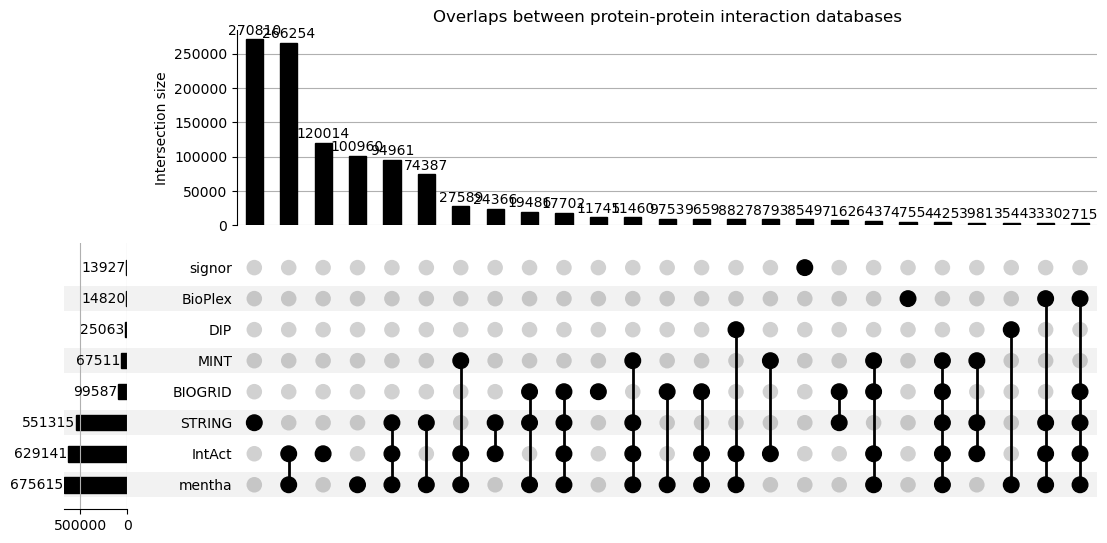

In [2]:
dstack = pd.read_pickle('../data/dstack.pkl.gz')

# sns.set(style='white')
upset = UpSet(dstack, subset_size='count', sort_by='cardinality', min_subset_size=2500, show_counts=True)
upset.plot()
plt.title("Overlaps between protein-protein interaction databases")
# plt.savefig('../figs/upset_min_subset_size_ppi_idmapping.pdf')

In [12]:
pd.read_csv('../ref/string/protein.physical.links.full.exp.v11.5.txt.gz', sep='\s+').shape

(1478734, 10)

#### Group proteins by orthology

In [2]:
biogrid = pd.read_pickle('../data/biogrid_.pkl.gz')
dip = pd.read_pickle('../data/dip_.pkl.gz')
intact = pd.read_pickle('../data/intact_.pkl.gz')
mentha = pd.read_pickle('../data/mentha_.pkl.gz')
mint = pd.read_pickle('../data/mint_.pkl.gz')
signor = pd.read_pickle('../data/signor_.pkl.gz')
bioplex = pd.read_pickle('../data/bioplex_.pkl.gz')
string = pd.read_pickle('../data/string_.pkl.gz')

biogrid_ortho = biogrid[~biogrid['OrthoDB pairs'].str.contains('NaN')]
biogrid_ortho = biogrid_ortho.drop_duplicates(['OrthoDB pairs','Taxid pairs'])
biogrid_ortho = biogrid_ortho[biogrid_ortho['Taxid pairs'].str.split('_').apply(lambda x: x[0]==x[1])]
biogrid_ortho = biogrid_ortho.value_counts('OrthoDB pairs').reset_index()
biogrid_ortho.columns = ['OrthoDB pairs','Counts']
biogrid_ortho['DB'] = 'BIOGRID'

dip_ortho = dip[~dip['OrthoDB pairs'].str.contains('NaN')]
dip_ortho = dip_ortho.drop_duplicates(['OrthoDB pairs','Taxid pairs'])
dip_ortho = dip_ortho[dip_ortho['Taxid pairs'].str.split('_').apply(lambda x: x[0]==x[1])]
dip_ortho = dip_ortho.value_counts('OrthoDB pairs').reset_index()
dip_ortho.columns = ['OrthoDB pairs','Counts']
dip_ortho['DB'] = 'DIP'

intact_ortho = intact[~intact['OrthoDB pairs'].str.contains('NaN')]
intact_ortho = intact_ortho.drop_duplicates(['OrthoDB pairs','Taxid pairs'])
intact_ortho = intact_ortho[intact_ortho['Taxid pairs'].str.split('_').apply(lambda x: x[0]==x[1])]
intact_ortho = intact_ortho.value_counts('OrthoDB pairs').reset_index()
intact_ortho.columns = ['OrthoDB pairs','Counts']
intact_ortho['DB'] = 'IntAct'

mentha_ortho = mentha[~mentha['OrthoDB pairs'].str.contains('NaN')]
mentha_ortho = mentha_ortho.drop_duplicates(['OrthoDB pairs','Taxid pairs'])
mentha_ortho = mentha_ortho[mentha_ortho['Taxid pairs'].str.split('_').apply(lambda x: x[0]==x[1])]
mentha_ortho = mentha_ortho.value_counts('OrthoDB pairs').reset_index()
mentha_ortho.columns = ['OrthoDB pairs','Counts']
mentha_ortho['DB'] = 'mentha'

mint_ortho = mint[~mint['OrthoDB pairs'].str.contains('NaN')]
mint_ortho = mint_ortho.drop_duplicates(['OrthoDB pairs','Taxid pairs'])
mint_ortho = mint_ortho[mint_ortho['Taxid pairs'].str.split('_').apply(lambda x: x[0]==x[1])]
mint_ortho = mint_ortho.value_counts('OrthoDB pairs').reset_index()
mint_ortho.columns = ['OrthoDB pairs','Counts']
mint_ortho['DB'] = 'MINT'

signor_ortho = signor[~signor['OrthoDB pairs'].str.contains('NaN')]
signor_ortho = signor_ortho.drop_duplicates(['OrthoDB pairs','Taxid pairs'])
signor_ortho = signor_ortho[signor_ortho['Taxid pairs'].str.split('_').apply(lambda x: x[0]==x[1])]
signor_ortho = signor_ortho.value_counts('OrthoDB pairs').reset_index()
signor_ortho.columns = ['OrthoDB pairs','Counts']
signor_ortho['DB'] = 'signor'

bioplex_ortho = bioplex[~bioplex['OrthoDB pairs'].str.contains('NaN')]
bioplex_ortho = bioplex_ortho.drop_duplicates(['OrthoDB pairs','Taxid pairs'])
bioplex_ortho = bioplex_ortho[bioplex_ortho['Taxid pairs'].str.split('_').apply(lambda x: x[0]==x[1])]
bioplex_ortho = bioplex_ortho.value_counts('OrthoDB pairs').reset_index()
bioplex_ortho.columns = ['OrthoDB pairs','Counts']
bioplex_ortho['DB'] = 'BioPlex'

string_ortho = string[~string['OrthoDB pairs'].str.contains('NaN')]
string_ortho = string_ortho.drop_duplicates(['OrthoDB pairs','Taxid pairs'])
string_ortho = string_ortho[string_ortho['Taxid pairs'].str.split('_').apply(lambda x: x[0]==x[1])]
string_ortho = string_ortho.value_counts('OrthoDB pairs').reset_index()
string_ortho.columns = ['OrthoDB pairs','Counts']
string_ortho['DB'] = 'STRING'

In [3]:
ortho_counts = pd.concat([biogrid_ortho,dip_ortho,intact_ortho,mentha_ortho,mint_ortho,signor_ortho,bioplex_ortho,string_ortho])
ortho_counts.to_pickle('../data/ortho_counts.pkl.gz')
# ortho_counts = pd.read_pickle('../data/ortho_counts.pkl.gz')

oc1 = ortho_counts[ortho_counts.Counts==1].value_counts('DB').reset_index()
oc1['Number of species'] = 'One'
oc2 = ortho_counts[ortho_counts.Counts>1].value_counts('DB').reset_index()
oc2['Number of species'] = 'Multiple'

ocounts = pd.concat([oc1,oc2])
ocounts.columns = ['DB','Counts','Number of species']

ocounts.pivot(index='Number of species', columns='DB', values='Counts')\
[['signor', 'BioPlex', 'DIP', 'MINT', 'BIOGRID', 'IntAct', 'mentha', 'STRING']]

DB                 signor  BioPlex      DIP     MINT  BIOGRID    IntAct  \
Number of species                                                         
Multiple              NaN      NaN    475.0   1175.0   3545.0   10156.0   
One                8533.0  12341.0  17037.0  47396.0  62024.0  385265.0   

DB                   mentha    STRING  
Number of species                      
Multiple            16499.0   32637.0  
One                446357.0  294303.0

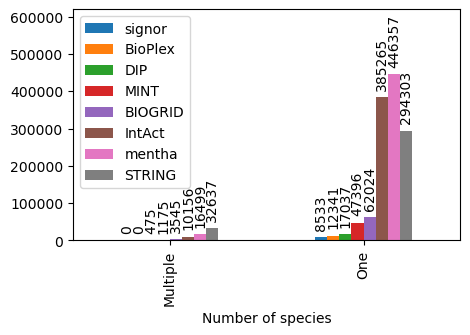

In [4]:
ax=ocounts.pivot(index='Number of species', columns='DB', values='Counts')\
[['signor', 'BioPlex', 'DIP', 'MINT', 'BIOGRID', 'IntAct', 'mentha', 'STRING']]\
.plot.bar(legend='reverse', stacked=False, figsize=(5,3))
# plt.yscale('log')
plt.ylim(0, 620000)
for container in ax.containers:
    ax.bar_label(container, rotation=90, padding=5)
plt.legend(title=None)#loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('../figs/barplot_counts_conserved_ppi.pdf')

In [5]:
import pandas as pd

biogrid = pd.read_pickle('../data/biogrid_.pkl.gz')
dip = pd.read_pickle('../data/dip_.pkl.gz')
intact = pd.read_pickle('../data/intact_.pkl.gz')
mentha = pd.read_pickle('../data/mentha_.pkl.gz')
mint = pd.read_pickle('../data/mint_.pkl.gz')
signor = pd.read_pickle('../data/signor_.pkl.gz')
bioplex = pd.read_pickle('../data/bioplex_.pkl.gz')
string = pd.read_pickle('../data/string_.pkl.gz')

db = pd.concat([biogrid,dip,intact,mentha,mint,signor,bioplex,string])

In [6]:
db_ortho = db[~db['OrthoDB pairs'].str.contains('NaN')]
db_ortho = db_ortho.drop_duplicates(['OrthoDB pairs','Taxid pairs'])

In [8]:
db_ortho[db_ortho['OrthoDB pairs']=='1614410at2759_2874082at2759']

BIOGRID          Pairs       Taxsum                OrthoDB pairs  \
79163       NaN  P41221_Q01973    9606_9606  1614410at2759_2874082at2759   
343066      NaN  P31285_Q13308    8355_9606  1614410at2759_2874082at2759   
741985      NaN  G5EGK5_P34888    6239_6239  1614410at2759_2874082at2759   
868769      NaN  P40589_Q6AWJ9    7227_7227  1614410at2759_2874082at2759   
1027274     NaN  P31285_Q6PA07    8355_8355  1614410at2759_2874082at2759   
1171241     NaN  P27467_Q01887  10090_10090  1614410at2759_2874082at2759   

                                      PDB  \
79163    [nan, 5Z55;6BA5;6BAN;6TU9;7TNG;]   
343066                       [nan, 6VG3;]   
741985                         [nan, nan]   
868769                       [nan, 6S9F;]   
1027274                        [nan, nan]   
1171241                        [nan, nan]   

                                                 Organisms  Taxid pairs  \
79163           Homo sapiens (Human)__Homo sapiens (Human)    9606_9606   
343066   Homo sapiens (Human)__Xenopus laevis (African ...    8355_9606   
741985      Caenorhabditis elegans__Caenorhabditis elegans    6239_6239   
868769   Drosophila melanogaster (Fruit fly)__Drosophil...    7227_7227   
1027274  Xenopus laevis (African clawed frog)__Xenopus ...    8355_8355   
1171241         Mus musculus (Mouse)__Mus musculus (Mouse)  10090_10090   

                                                       DIP  \
79163    DIP-29734N|refseq:NP_005003|uniprotkb:Q01973_D...   
343066                                                 NaN   
741985                                                 NaN   
868769                                                 NaN   
1027274                                                NaN   
1171241                                                NaN   

                                    IntAct                             mentha  \
79163                                  NaN                                NaN   
343066   uniprotkb:P31285_uniprotkb:Q13308                                NaN   
741985   uniprotkb:G5EGK5_uniprotkb:P34888                                NaN   
868769   uniprotkb:P40589_uniprotkb:Q6AWJ9                                NaN   
1027274  uniprotkb:P31285_uniprotkb:Q6PA07                                NaN   
1171241                                NaN  uniprotkb:P27467_uniprotkb:Q01887   

        MINT signor BioPlex STRING  
79163    NaN    NaN     NaN    NaN  
343066   NaN    NaN     NaN    NaN  
741985   NaN    NaN     NaN    NaN  
868769   NaN    NaN     NaN    NaN  
1027274  NaN    NaN     NaN    NaN  
1171241  NaN    NaN     NaN    NaN

#### PPIs supported by 3D structures

In [2]:
biogrid = pd.read_pickle('../data/biogrid_.pkl.gz')
dip = pd.read_pickle('../data/dip_.pkl.gz')
intact = pd.read_pickle('../data/intact_.pkl.gz')
mentha = pd.read_pickle('../data/mentha_.pkl.gz')
mint = pd.read_pickle('../data/mint_.pkl.gz')
signor = pd.read_pickle('../data/signor_.pkl.gz')
bioplex = pd.read_pickle('../data/bioplex_.pkl.gz')
string = pd.read_pickle('../data/string_.pkl.gz')

db = pd.concat([biogrid,dip,intact,mentha,mint,signor,bioplex,string])
db_ortho = db[~db['OrthoDB pairs'].str.contains('NaN')]
db_ortho = db_ortho.drop_duplicates(['OrthoDB pairs','Taxid pairs'])
db_ortho = db_ortho[db_ortho['Taxid pairs'].str.split('_').apply(lambda x: x[0]==x[1])]
db_ortho = db_ortho.value_counts('OrthoDB pairs').reset_index()
db_ortho.columns = ['OrthoDB pairs','Counts']

pdb_ppi = pd.merge(db_ortho, db[(~db['OrthoDB pairs'].str.contains('OrthoDB_NaN')) & \
                               (db.PDB.apply(lambda x: type(x[0]) is str)) & \
                               (db.PDB.apply(lambda x: type(x[1]) is str))]\
                  [['OrthoDB pairs','PDB']])
pdb_ppi['Complex PDB'] = pdb_ppi.PDB\
.apply(lambda x: sorted(list(set(x[0].split(';')[:-1]).intersection(set(x[1].split(';')[:-1])))))
pdb_ppi['flatten'] = pdb_ppi['Complex PDB'].apply(lambda x: '_'.join(x))
pdb_ppi = pdb_ppi.drop_duplicates(['OrthoDB pairs','flatten'])
pdb_ppi_solved = pdb_ppi[pdb_ppi.flatten.apply(lambda x: len(x)>0)].copy()
pdb_ppi_solved['Solved'] = 1
pdb_ppi_unsolved = pdb_ppi[pdb_ppi.flatten.apply(lambda x: len(x)==0)].copy()
pdb_ppi_unsolved['Solved'] = 0
pdb_ppi = pd.concat([pdb_ppi_solved,pdb_ppi_unsolved])

solved_ids = pdb_ppi[pdb_ppi.Solved==1].drop_duplicates('OrthoDB pairs')[['OrthoDB pairs']]
unsolved_ids = pdb_ppi[pdb_ppi.Solved==0].drop_duplicates('OrthoDB pairs')[['OrthoDB pairs']]
unsolved_ids = pd.concat([solved_ids,solved_ids,unsolved_ids]).drop_duplicates('OrthoDB pairs',keep=False)
solved_ids = pd.merge(solved_ids,pdb_ppi[pdb_ppi.Solved==1])
unsolved_ids = pd.merge(unsolved_ids,pdb_ppi[pdb_ppi.Solved==0])
pdb_ppi = pd.concat([solved_ids,unsolved_ids])

pdb_ppi.to_pickle('../data/pdb_ppi.pkl.gz')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 

In [2]:
u = pd.read_pickle('../data/idmapping.pkl.gz')
u['OrthoDB'] = u.OrthoDB.fillna('OrthoDB_NaN;').str.split(';').apply(lambda x: x[0])
dstack = pd.read_pickle('../data/dstack.pkl.gz')

pdb_ppi = pd.read_pickle('../data/pdb_ppi.pkl.gz')
pdb_ppi_counts = pdb_ppi.value_counts(['Counts','Solved']).reset_index().sort_values(['Counts','Solved']).groupby('Counts').agg(list).reset_index()

# https://stackoverflow.com/a/952952
xss = pdb_ppi['Complex PDB'].tolist()
flat_list = [
    x
    for xs in xss
    for x in xs
]

len(flat_list), len(set(flat_list))

(815540, 60755)

(0.0, 100.0)

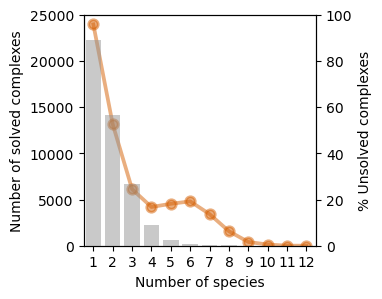

In [3]:
frac_unsolved = pdb_ppi_counts['count'].apply(lambda x: 100- x[-1]/(np.sum(x))*100).tolist()
pdb_ppi_counts['% Unsolved complexes'] = frac_unsolved


pal=sns.color_palette('colorblind')
plt.figure(figsize=(3,3))
ax1=sns.pointplot(data=pdb_ppi_counts, x='Counts', y=pdb_ppi_counts['count'].apply(lambda x: x[-1]), 
              color=pal.as_hex()[3], alpha=0.5)
ax1.set_xlabel('Number of species')
ax1.set_ylabel('Number of solved complexes')
ax1.set_ylim(0,25000)

ax2 = plt.twinx()
sns.barplot(data=pdb_ppi_counts,x='Counts',y='% Unsolved complexes', color=pal.as_hex()[-3], 
            ax=ax2, alpha=0.5)
ax2.set_xlabel('Number of species')
ax2.set_ylim(0,100)
plt.savefig('../figs/barplot_unsolved_complexes.pdf', bbox_inches='tight')

In [4]:
pdb_ppi_counts

Counts  Solved            count  % Unsolved complexes
0        1  [0, 1]  [194676, 23953]             89.043997
1        2  [0, 1]   [17076, 13146]             56.501886
2        3  [0, 1]     [2237, 6119]             26.771182
3        4  [0, 1]      [422, 4192]              9.146077
4        5  [0, 1]      [105, 4538]              2.261469
5        6  [0, 1]       [35, 4802]              0.723589
6        7  [0, 1]       [13, 3419]              0.378788
7        8  [0, 1]        [3, 1565]              0.191327
8        9     [1]            [406]              0.000000
9       10     [1]            [129]              0.000000
10      11     [1]              [7]              0.000000
11      12     [1]              [4]              0.000000

In [5]:
c1 = pdb_ppi_counts[pdb_ppi_counts.Counts==1]['count'].iloc[0]

fisher_tests = []
for i in range(2,13):
    cn = pdb_ppi_counts[pdb_ppi_counts.Counts==i]['count'].iloc[0]
    if len(cn)==1:
        cn = [0] + cn
    ctab = [c1,cn]
    odds_ratio, p_value = stats.fisher_exact(ctab, alternative='greater')
    fisher_tests.append([ctab, i, odds_ratio, p_value])

fisher_tests = pd.DataFrame(fisher_tests)
fisher_tests.columns = ['cross tab','Counts','Odds ratio','p-value']

In [6]:
fisher_tests

cross tab  Counts   Odds ratio        p-value
0   [[194676, 23953], [17076, 13146]]       2     6.256911   0.000000e+00
1     [[194676, 23953], [2237, 6119]]       3    22.231408   0.000000e+00
2      [[194676, 23953], [422, 4192]]       4    80.734902   0.000000e+00
3      [[194676, 23953], [105, 4538]]       5   351.259187   0.000000e+00
4       [[194676, 23953], [35, 4802]]       6  1115.081501   0.000000e+00
5       [[194676, 23953], [13, 3419]]       7  2137.510458   0.000000e+00
6        [[194676, 23953], [3, 1565]]       8  4239.802112   0.000000e+00
7         [[194676, 23953], [0, 406]]       9          inf   0.000000e+00
8         [[194676, 23953], [0, 129]]      10          inf  1.779221e-124
9           [[194676, 23953], [0, 7]]      11          inf   1.896780e-07
10          [[194676, 23953], [0, 4]]      12          inf   1.441352e-04

In [5]:
# Solved complexes
solved_complexes = []

for i in range(2,13):
    solved = solved_ids[(solved_ids.Counts==i)].copy()
    solved['OrthoDB'] = solved['OrthoDB pairs'].apply(lambda x: x.split('_')[0])
    solved = pd.merge(u, solved[['OrthoDB pairs','OrthoDB']])
    solved['OrthoDB'] = solved['OrthoDB pairs'].apply(lambda x: x.split('_')[1])
    solved = pd.merge(u, solved, on='OrthoDB')
    solved['Pairs'] = solved[['Entry_x','Entry_y']].values.tolist()
    solved['Pairs'] = solved['Pairs'].apply(lambda x: '_'.join(sorted(x)))
    solved = pd.merge(dstack,solved).drop_duplicates('Pairs')
    solved['Number of species'] = i
    solved_complexes.append(solved)

solved_complexes = pd.concat(solved_complexes)
solved_complexes.to_pickle('../data/solved_complexes.pkl.gz')

In [6]:
# solved_complexes = pd.read_pickle('../data/solved_complexes.pkl.gz')
solved_KEGG = pd.DataFrame(np.vstack([solved_complexes[['Entry_x','KEGG_x','Number of species']].dropna(),
                                      solved_complexes[['Entry_y','KEGG_y','Number of species']].dropna()]),
          columns=['Entry','KEGG','Number of species'])
solved_KEGG['KEGG'] = solved_KEGG.KEGG.str.split(';').apply(lambda x: [i for i in x if i])
solved_KEGG = solved_KEGG.explode('KEGG')
solved_KEGG.columns = ['UniProt','KEGG','Number of species']
solved_KEGG = solved_KEGG.drop_duplicates()
solved_KEGG.to_pickle('../data/solved_KEGG.pkl.gz')

In [8]:
# KEGG Pathway
keggpath = []

for i in solved_KEGG[['UniProt','KEGG']].drop_duplicates().values.tolist():
    org=i[1].split(':')[0]
    kg=i[1].split(':')[1]
    k=pd.read_html('https://www.kegg.jp/kegg-bin/search_pathway_text?map=' + org + '&keyword=' + kg)[1]
    k['UniProt']=i[0]
    keggpath.append(k)
    
keggpath=pd.concat(keggpath)
keggpath.to_pickle('../data/solved_keggpath.pkl.gz')

In [7]:
u = pd.read_pickle('../data/idmapping.pkl.gz')
u['OrthoDB'] = u.OrthoDB.fillna('OrthoDB_NaN;').str.split(';').apply(lambda x: x[0])
keggpath = pd.read_pickle('../data/solved_keggpath.pkl.gz')
solved_KEGG = pd.read_pickle('../data/solved_KEGG.pkl.gz')

keggpath_nan = keggpath[keggpath.Entry.isna()]
keggpath = keggpath[~keggpath.Entry.isna()]
keggpath = keggpath[keggpath.Entry.apply(lambda x: int([*x][-4]))<5]
keggpath = keggpath[(~keggpath.Entry.str.contains('4932')) & (~keggpath.Entry.str.contains('4936'))]
keggpath = pd.merge(solved_KEGG,keggpath)
keggpath = pd.merge(keggpath, u[['Entry','OrthoDB']].rename(columns={'Entry':'UniProt'}))
keggpath.to_pickle('../data/solved_keggpath_ids.pkl.gz')

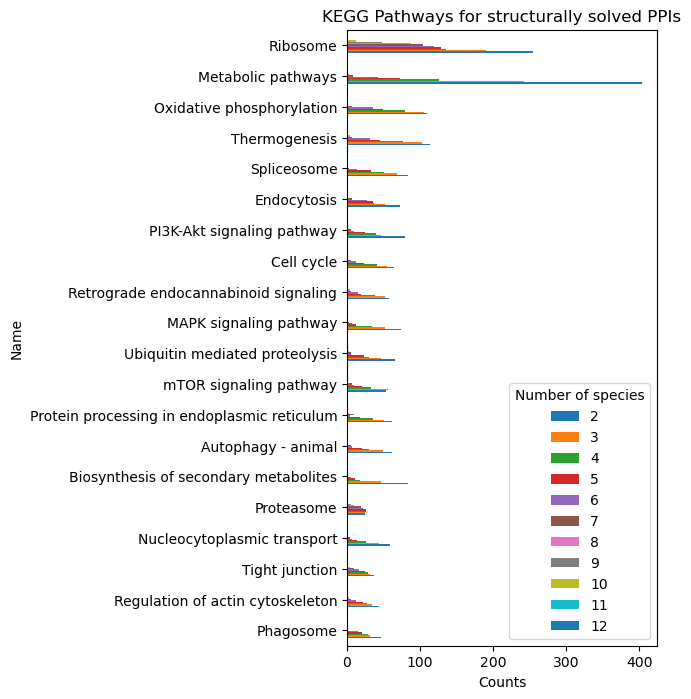

In [8]:
keggpath = pd.read_pickle('../data/solved_keggpath_ids.pkl.gz')

keggpath = keggpath[['OrthoDB','Name','Number of species']].drop_duplicates()
keggpath_counts = keggpath.value_counts(['Number of species','Name']).reset_index().pivot(index='Name', columns='Number of species', values='count')
keggpath_counts = keggpath_counts.fillna(0) #.sort_values([12,11,10,9,8,7,6,5,4,3,2])
keggpath_counts['sum'] = keggpath_counts[[12,11,10,9,8,7,6,5,4,3,2]].values.tolist()
keggpath_counts['sum'] = keggpath_counts['sum'].apply(lambda x: np.sum(x))

keggpath_counts.sort_values('sum').drop('sum', axis=1).tail(20).plot.barh(figsize=(4,8))
plt.xlabel('Counts')
plt.title('KEGG Pathways for structurally solved PPIs')
plt.savefig('../figs/keggpath_counts.pdf')

In [9]:
# Unsolved complexes

unsolved_complexes = []

for i in range(2,9):
    unsolved = unsolved_ids[(unsolved_ids.Counts==i)].copy()
    unsolved['OrthoDB'] = unsolved['OrthoDB pairs'].apply(lambda x: x.split('_')[0])
    unsolved = pd.merge(u, unsolved[['OrthoDB pairs','OrthoDB']])
    unsolved['OrthoDB'] = unsolved['OrthoDB pairs'].apply(lambda x: x.split('_')[1])
    unsolved = pd.merge(u, unsolved, on='OrthoDB')
    unsolved['Pairs'] = unsolved[['Entry_x','Entry_y']].values.tolist()
    unsolved['Pairs'] = unsolved['Pairs'].apply(lambda x: '_'.join(sorted(x)))
    unsolved = pd.merge(dstack,unsolved).drop_duplicates('Pairs')
    unsolved['Number of species'] = i
    unsolved_complexes.append(unsolved)

unsolved_complexes = pd.concat(unsolved_complexes)
unsolved_complexes.to_pickle('../data/unsolved_complexes.pkl.gz')

In [10]:
# unsolved_complexes = pd.read_pickle('../data/unsolved_complexes.pkl.gz')
unsolved_KEGG = pd.DataFrame(np.vstack([unsolved_complexes[['Entry_x','KEGG_x','Number of species']].dropna(),
                                      unsolved_complexes[['Entry_y','KEGG_y','Number of species']].dropna()]),
          columns=['Entry','KEGG','Number of species'])
unsolved_KEGG['KEGG'] = unsolved_KEGG.KEGG.str.split(';').apply(lambda x: [i for i in x if i])
unsolved_KEGG = unsolved_KEGG.explode('KEGG')
unsolved_KEGG.columns = ['UniProt','KEGG','Number of species']
unsolved_KEGG = unsolved_KEGG.drop_duplicates()
unsolved_KEGG.to_pickle('../data/unsolved_KEGG.pkl.gz')

In [11]:
x=set(pd.read_pickle('../data/unsolved_KEGG.pkl.gz').UniProt.unique())
y=set(pd.read_pickle('../data/unsolved_keggpath.pkl.gz').UniProt.unique())
len(x.difference(y)),len(y.difference(x))
# unsolved_KEGG = pd.merge(pd.DataFrame({'UniProt':list(x.difference(y))}),
#                          pd.read_pickle('../data/unsolved_KEGG.pkl.gz'))

(0, 7953)

In [3]:
# KEGG Pathway
keggpath = []

for i in unsolved_KEGG[['UniProt','KEGG']].drop_duplicates().values.tolist():
    org=i[1].split(':')[0]
    kg=i[1].split(':')[1]
    k=pd.read_html('https://www.kegg.jp/kegg-bin/search_pathway_text?map=' + org + '&keyword=' + kg)[1]
    k['UniProt']=i[0]
    keggpath.append(k)
    
keggpath=pd.concat(keggpath)
keggpath.to_pickle('../data/unsolved_keggpath.pkl.gz')

In [12]:
u = pd.read_pickle('../data/idmapping.pkl.gz')
u['OrthoDB'] = u.OrthoDB.fillna('OrthoDB_NaN;').str.split(';').apply(lambda x: x[0])
keggpath = pd.read_pickle('../data/unsolved_keggpath.pkl.gz')
unsolved_KEGG = pd.read_pickle('../data/unsolved_KEGG.pkl.gz')

keggpath_nan = keggpath[keggpath.Entry.isna()]
keggpath = keggpath[~keggpath.Entry.isna()]
keggpath = keggpath[keggpath.Entry.apply(lambda x: int([*x][-4]))<5]
keggpath = keggpath[(~keggpath.Entry.str.contains('4932')) & (~keggpath.Entry.str.contains('4936'))]
keggpath = pd.merge(unsolved_KEGG,keggpath)
keggpath = pd.merge(keggpath, u[['Entry','OrthoDB']].rename(columns={'Entry':'UniProt'}))
keggpath.to_pickle('../data/unsolved_keggpath_ids.pkl.gz')

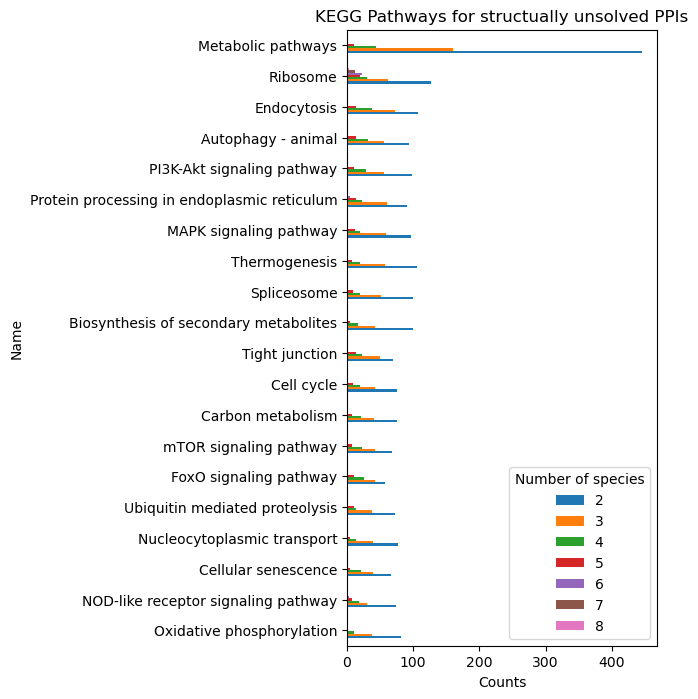

In [14]:
keggpath = pd.read_pickle('../data/unsolved_keggpath_ids.pkl.gz')

keggpath = keggpath[['OrthoDB','Name','Number of species']].drop_duplicates()
keggpath_counts = keggpath.value_counts(['Number of species','Name']).reset_index().pivot(index='Name', columns='Number of species', values='count')
keggpath_counts = keggpath_counts.fillna(0) #.sort_values([8,7,6,5,4,3,2])
keggpath_counts['sum'] = keggpath_counts[[8,7,6,5,4,3,2]].values.tolist()
keggpath_counts['sum'] = keggpath_counts['sum'].apply(lambda x: np.sum(x))

keggpath_counts.sort_values('sum').drop('sum', axis=1).tail(20).plot.barh(figsize=(4,8))
plt.xlabel('Counts')
plt.title('KEGG Pathways for structually unsolved PPIs')
plt.savefig('../figs/keggpath_unsolved_counts.pdf')

In [1]:
import pandas as pd

dstack = pd.read_pickle('../data/dstack.pkl.gz')
dstack = dstack.reset_index()
dstack['DB'] = dstack[['BIOGRID','DIP','IntAct','mentha','MINT','signor','BioPlex','STRING']].values.tolist()
dstack.drop(['BIOGRID','DIP','IntAct','mentha','MINT','signor','BioPlex','STRING'], 
            axis=1, inplace=True)

pdb_ppi = pd.read_pickle('../data/pdb_ppi.pkl.gz')
solved_ids = pdb_ppi[pdb_ppi.Solved==1].drop_duplicates('OrthoDB pairs')
unsolved_ids = pdb_ppi[pdb_ppi.Solved==0].drop_duplicates('OrthoDB pairs')

solved_keggpath = pd.read_pickle('../data/solved_keggpath_ids.pkl.gz')
unsolved_keggpath = pd.read_pickle('../data/unsolved_keggpath_ids.pkl.gz')

# unsolved_metpaths = unsolved_keggpath[(~unsolved_keggpath.Name.str.contains('Ribosome|Proteosome|Spliceosome'))].copy()
unsolved_metpaths = unsolved_keggpath
unsolved_metpaths['KEGG'] = unsolved_metpaths[['KEGG','Name']].values.tolist()
unsolved_metpaths['KEGG'] = unsolved_metpaths['KEGG'].apply(lambda x: '|'.join(x))
unsolved_metpaths = unsolved_metpaths.groupby(['UniProt','OrthoDB','Number of species'])['KEGG'].apply(set).reset_index()
unsolved_metpaths.shape

(17848, 4)

In [2]:
unsolved_ids['OrthoDB'] = unsolved_ids['OrthoDB pairs'].str.split('_').apply(lambda x: x[1])
unmet = pd.merge(unsolved_metpaths,unsolved_ids,on='OrthoDB')
unmet.rename(columns={'OrthoDB':'OrthoDB_y'}, inplace=True)
unmet['OrthoDB'] = unmet['OrthoDB pairs'].str.split('_').apply(lambda x: x[0])
unmet = pd.merge(unsolved_metpaths,unmet,on='OrthoDB')
unmet.rename(columns={'OrthoDB':'OrthoDB_x'}, inplace=True)
unmet['OrthoDB'] = unmet[['OrthoDB_x','OrthoDB_y']].values.tolist()
unmet['OrthoDB'] = unmet['OrthoDB'].apply(lambda x: '_'.join(sorted(x)))
unmet = unmet[(unmet['OrthoDB']==unmet['OrthoDB pairs']) & (unmet.Solved==0)].drop('OrthoDB',axis=1)
unmet = unmet.sort_values('Counts',ascending=False).drop_duplicates(['UniProt_x','UniProt_y','OrthoDB pairs'])
unmet['PDB counts'] = unmet.PDB.apply(lambda x: [len(x[0].split(';'))-1, len(x[1].split(';'))-1])

unmet['Pairs'] = unmet[['UniProt_x','UniProt_y']].values.tolist()
unmet['Pairs'] = unmet['Pairs'].apply(lambda x: '_'.join(sorted(x)))
unmet = pd.merge(unmet,dstack)
unmet = unmet[(unmet['Counts']==unmet['Number of species_y']) & (unmet['Number of species_x']==unmet['Number of species_y'])]
unmet.rename(columns={'Number of species_x':'Number of species','UniProt_x':'Entry_x','UniProt_y':'Entry_y'}, inplace=True)
unmet['PPI DB counts'] = unmet.DB.apply(lambda x: sum(x))
unmet = unmet[['Pairs','OrthoDB pairs','Number of species','KEGG_x','KEGG_y','PPI DB counts','DB']].drop_duplicates('Pairs')

In [3]:
u = pd.read_pickle('../data/idmapping.pkl.gz')
u = u[['Entry','Gene Names','Protein names','Organism']]

unmet['Entry_y'] = unmet.Pairs.str.split('_').apply(lambda x: x[1])
unmet = pd.merge(u.rename(columns = {'Entry':'Entry_y','Gene Names':'Gene Names_x','Protein names':'Protein names_y'}),unmet)
unmet['Entry_x'] = unmet.Pairs.str.split('_').apply(lambda x: x[0])
unmet = pd.merge(u.rename(columns = {'Entry':'Entry_x','Gene Names':'Gene Names_y','Protein names':'Protein names_x'}),unmet)

orglist = unmet.groupby('OrthoDB pairs').Organism.apply(set).reset_index()
unmet = pd.merge(unmet.drop('Organism',axis=1),orglist)
unmet.rename(columns={'Organism':'Species'}, inplace=True)
unmet = unmet[['Pairs','OrthoDB pairs','Number of species','Species','Gene Names_x','Protein names_x','KEGG_x','Gene Names_y','Protein names_y','KEGG_y','PPI DB counts','DB']].drop_duplicates('Pairs')
unmet.to_csv('unsolved.csv',index=None)
unmet.to_pickle('../data/unsolved.pkl.gz')
unmet.to_csv('../data/unsolved.csv', index=None)

### Homologous PPIs

In [2]:
biogrid = pd.read_pickle('../data/biogrid_.pkl.gz')
dip = pd.read_pickle('../data/dip_.pkl.gz')
intact = pd.read_pickle('../data/intact_.pkl.gz')
mentha = pd.read_pickle('../data/mentha_.pkl.gz')
mint = pd.read_pickle('../data/mint_.pkl.gz')
signor = pd.read_pickle('../data/signor_.pkl.gz')
bioplex = pd.read_pickle('../data/bioplex_.pkl.gz')
string = pd.read_pickle('../data/string_.pkl.gz')

biogrid_cons = biogrid[['Pairs','OrthoDB pairs','Organisms']].drop_duplicates()
dip_cons = dip[['Pairs','OrthoDB pairs','Organisms']].drop_duplicates()
intact_cons = intact[['Pairs','OrthoDB pairs','Organisms']].drop_duplicates()
mentha_cons = mentha[['Pairs','OrthoDB pairs','Organisms']].drop_duplicates()
mint_cons = mint[['Pairs','OrthoDB pairs','Organisms']].drop_duplicates()
signor_cons = signor[['Pairs','OrthoDB pairs','Organisms']].drop_duplicates()
bioplex_cons = bioplex[['Pairs','OrthoDB pairs','Organisms']].drop_duplicates()
string_cons = string[['Pairs','OrthoDB pairs','Organisms']].drop_duplicates()

biogrid_cons['DB'] = 'BIOGRID'
dip_cons['DB'] = 'DIP'
intact_cons['DB'] = 'IntAct'
mentha_cons['DB'] = 'mentha'
mint_cons['DB'] = 'MINT'
signor_cons['DB'] = 'signor'
bioplex_cons['DB'] = 'BioPlex'
string_cons['DB'] = 'STRING'

db_cons = pd.concat([biogrid_cons,dip_cons,intact_cons,mentha_cons,mint_cons,signor_cons,bioplex_cons,string_cons])
db_cons = db_cons[~db_cons['OrthoDB pairs'].str.contains('NaN')]
db_cons = db_cons[db_cons.Organisms.str.split('__').apply(lambda x: x[0]==x[1])].copy()
db_cons['Organisms'] = db_cons.Organisms.str.split('__').apply(lambda x: x[0])
db_cons.to_pickle('../data/db_cons_ids.pkl.gz')


biogrid_cons = biogrid[['OrthoDB pairs','Organisms']].drop_duplicates()
dip_cons = dip[['OrthoDB pairs','Organisms']].drop_duplicates()
intact_cons = intact[['OrthoDB pairs','Organisms']].drop_duplicates()
mentha_cons = mentha[['OrthoDB pairs','Organisms']].drop_duplicates()
mint_cons = mint[['OrthoDB pairs','Organisms']].drop_duplicates()
signor_cons = signor[['OrthoDB pairs','Organisms']].drop_duplicates()
bioplex_cons = bioplex[['OrthoDB pairs','Organisms']].drop_duplicates()
string_cons = string[['OrthoDB pairs','Organisms']].drop_duplicates()

biogrid_cons['DB'] = 'BIOGRID'
dip_cons['DB'] = 'DIP'
intact_cons['DB'] = 'IntAct'
mentha_cons['DB'] = 'mentha'
mint_cons['DB'] = 'MINT'
signor_cons['DB'] = 'signor'
bioplex_cons['DB'] = 'BioPlex'
string_cons['DB'] = 'STRING'

db_cons = pd.concat([biogrid_cons,dip_cons,intact_cons,mentha_cons,mint_cons,signor_cons,bioplex_cons,string_cons])
db_cons = db_cons[~db_cons['OrthoDB pairs'].str.contains('NaN')]
db_cons = db_cons[db_cons.Organisms.str.split('__').apply(lambda x: x[0]==x[1])].copy()
db_cons['Organisms'] = db_cons.Organisms.str.split('__').apply(lambda x: x[0])

db_cons_counts = db_cons.drop_duplicates(['OrthoDB pairs','DB']).value_counts('OrthoDB pairs').reset_index()
db_cons_counts.columns = ['OrthoDB pairs','Counts']
db_cons_counts = db_cons_counts[db_cons_counts['Counts']>1]

db_cons = pd.merge(db_cons, db_cons_counts[['OrthoDB pairs']]).drop('DB', axis=1).drop_duplicates()
db_cons['Interact'] = True
db_cons.to_pickle('../data/db_cons.pkl.gz')
# sns.histplot(data=db_cons_counts,x='Counts')

/Volumes/scratch/gardnerlab/cslim/tmp/ipykernel_111915/2671329721.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dstack = dstack.reset_index().fillna(False).set_index(cols)
/Volumes/scratch/limlab/anaconda3/envs/straw/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original

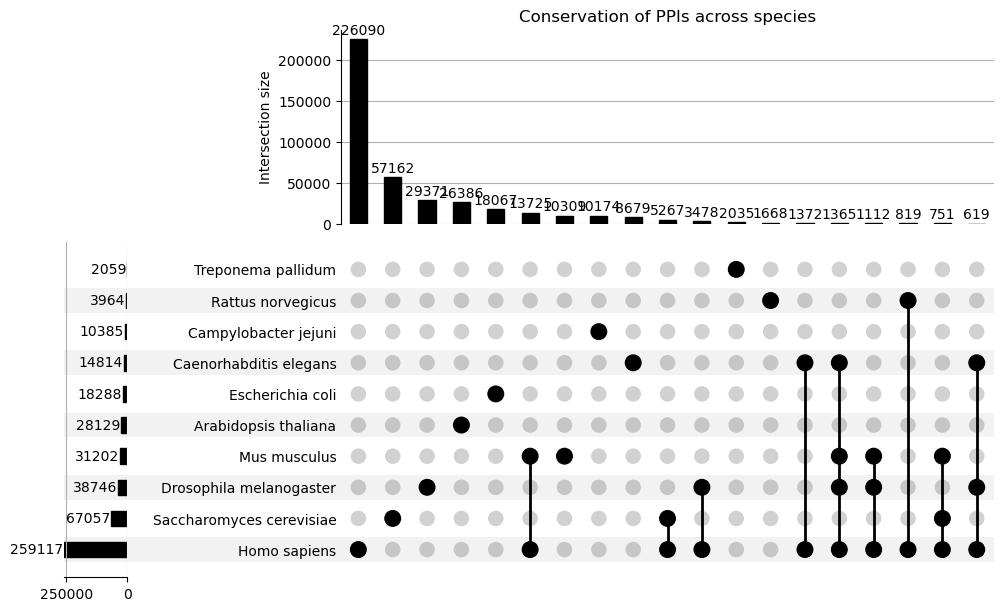

In [3]:
dstack = pd.merge(db_cons,db_cons.value_counts('Organisms').head(10).reset_index()[['Organisms']])
dstack = dstack.set_index('OrthoDB pairs').set_index('Organisms', append=True).unstack(level='Organisms')
dstack.to_pickle('../data/dstack_species.pkl.gz')

cols = [i[1] for i in dstack.columns]
cols = [' '.join(i.split()[:2]) for i in cols]
dstack.columns = cols
dstack = dstack.reset_index().fillna(False).set_index(cols)

# sns.set(style='white')
upset = UpSet(dstack, subset_size='count', sort_by='cardinality', min_subset_size=500, show_counts=True)
upset.plot()
plt.title("Conservation of PPIs across species")
plt.savefig('../figs/upset_conserved_ppi.pdf')
plt.show()

#### Distribution of species

In [2]:
d = pd.read_pickle('../data/dstack.pkl.gz').reset_index()
po = d.drop_duplicates('Pairs').Pairs.str.split('_', expand=True)
po = pd.DataFrame({'Entry':list(set(po[0].tolist() + po[1].tolist()))})

u = pd.read_pickle('../data/idmapping.pkl.gz')[['Entry','Organism']].drop_duplicates('Entry')
po = pd.merge(u,po)

po = po.Organism.value_counts()[:10].reset_index()
po['Organism'] = po['Organism'].str.split(' \(').apply(lambda x: x[0])
po['Organism'] = po['Organism'].replace('Synechocystis sp.','Synechocystis sp. PCC 6803')
po.set_index('Organism', inplace=True)

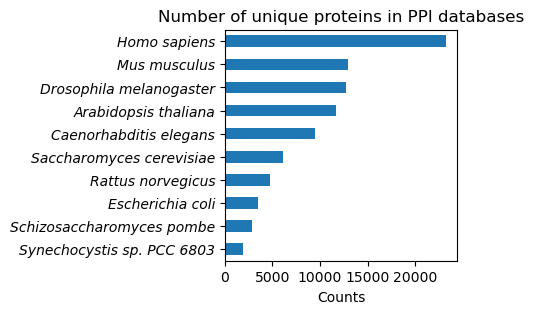

In [4]:
po = po.sort_values('count')
g = po.plot.barh(figsize=(3,3),legend=False)
g.set_yticklabels(labels=po.index, fontstyle='italic')
plt.title('Number of unique proteins in PPI databases')
plt.xlabel('Counts')
g.set(ylabel=None)
plt.savefig('../figs/species_counts.pdf', bbox_inches='tight')

#### Overlap coefficients

In [2]:
clusters = []
for i in glob('../ref/uniprot/*_cluster.tsv'):
    c = pd.read_csv(i, sep='\t', header=None)
    c['Identity'] = i
#     c['Identity'] = c.Identity.str.split('_').apply(lambda x: x[1]).astype(float)
#     x = pd.DataFrame(c.groupby([0])[1].apply(list)).reset_index().reset_index()
#     g = pd.merge(x[['index',0]],c,on=[0])
    clusters.append(c)
    
clusters = pd.concat(clusters)
clusters['Identity'] = clusters.Identity.str.split('_').apply(lambda x: x[1]).astype(float)

In [3]:
d = pd.read_pickle('../data/dstack.pkl.gz').reset_index()
dbs = ['BIOGRID','DIP','IntAct','mentha','MINT','signor','BioPlex','STRING']

coefficients = []
pairs = []
for i in range(len(dbs)):
    pairs.append(d[d[dbs[i]]==True].Pairs.unique())
    
*inputs, = combinations(pairs, 2)
coefs = pd.DataFrame({'Overlap coefficient':list(starmap(overlap_coefficient, inputs)),
                      'Identity':1})
coefficients.append(coefs)


for q in clusters.Identity.unique():
    pairs = []
    for i in range(len(dbs)):
        p = pd.DataFrame({'Pairs':d[d[dbs[i]]==True].Pairs.unique()})
        p[1] = p.Pairs.str.split('_').apply(lambda x: x[0])
        p = pd.merge(p, clusters[clusters.Identity==q], on=[1]).drop([1,'Identity'],axis=1)
        p[1] = p.Pairs.str.split('_').apply(lambda x: x[1])
        p = pd.merge(p, clusters[clusters.Identity==q], on=[1]).drop([1],axis=1)
        p['Pairs'] = p[['0_x','0_y']].values.tolist()
        p['Pairs'] = p['Pairs'].apply(lambda x: '_'.join(sorted(x)))
        pairs.append(p.Pairs.unique())

    *inputs, = combinations(pairs, 2)
    coefs = pd.DataFrame({'Overlap coefficient':list(starmap(overlap_coefficient, inputs)),
                         'Identity':q})
    coefficients.append(coefs)
    
coefs = pd.concat(coefficients)
coefs.to_pickle('../data/overlap_coefs.pkl.gz')

In [3]:
coefs = pd.read_pickle('../data/overlap_coefs.pkl.gz')
coefs[coefs.Identity==1].sort_values('Overlap coefficient', ascending=False)

Overlap coefficient  Identity
14             1.000000       1.0
18             0.798255       1.0
8              0.796194       1.0
7              0.791765       1.0
2              0.771456       1.0
13             0.737661       1.0
20             0.610526       1.0
6              0.594646       1.0
16             0.594265       1.0
27             0.571862       1.0
1              0.494060       1.0
21             0.435221       1.0
12             0.363205       1.0
26             0.358369       1.0
24             0.348254       1.0
19             0.336182       1.0
5              0.324291       1.0
17             0.316977       1.0
4              0.220292       1.0
3              0.202767       1.0
15             0.200402       1.0
0              0.124327       1.0
9              0.099150       1.0
22             0.074316       1.0
23             0.063158       1.0
10             0.054068       1.0
11             0.023752       1.0
25             0.011273       1.0

In [4]:
coefficients = []
pairs = []
for i in range(len(dbs)):
    p = pd.DataFrame({'Pairs':d[d[dbs[i]]==True].Pairs.unique()})
    p['Protein1'] = p.Pairs.str.split('_').apply(lambda x: x[0])
    p['Protein2'] = p.Pairs.str.split('_').apply(lambda x: x[1])
    p = pd.concat([p.sample(p.shape[0],random_state=123)[['Protein1']].reset_index(),
                   p.sample(p.shape[0],random_state=456)[['Protein2']].reset_index()], 
                  axis=1)
    p['Pairs'] = p[['Protein1','Protein2']].values.tolist()
    p['Pairs'] = p['Pairs'].apply(lambda x: '_'.join(sorted(x)))
    pairs.append(p.Pairs.unique())
    
*inputs, = combinations(pairs, 2)
coefs_rand = pd.DataFrame({'Overlap coefficient':list(starmap(overlap_coefficient, inputs)),
                      'Identity':1})
coefficients.append(coefs_rand)


for q in clusters.Identity.unique():
    pairs = []
    for i in range(len(dbs)):
        p = pd.DataFrame({'Pairs':d[d[dbs[i]]==True].Pairs.unique()})
        p[1] = p.Pairs.str.split('_').apply(lambda x: x[0])
        p = pd.merge(p, clusters[clusters.Identity==q], on=[1]).drop([1,'Identity'],axis=1)
        p[1] = p.Pairs.str.split('_').apply(lambda x: x[1])
        p = pd.merge(p, clusters[clusters.Identity==q], on=[1]).drop([1],axis=1)
        p = pd.concat([p.sample(p.shape[0],random_state=123)[['0_x']].reset_index(),
                       p.sample(p.shape[0],random_state=456)[['0_y','Identity']].reset_index()], 
                      axis=1)
        p['Pairs'] = p[['0_x','0_y']].values.tolist()
        p['Pairs'] = p['Pairs'].apply(lambda x: '_'.join(sorted(x)))
        pairs.append(p.Pairs.unique())

    *inputs, = combinations(pairs, 2)
    coefs_rand = pd.DataFrame({'Overlap coefficient':list(starmap(overlap_coefficient, inputs)),
                         'Identity':q})
    coefficients.append(coefs_rand)
    
coefs_rand = pd.concat(coefficients)
coefs_rand.to_pickle('../data/overlap_coefs_rand.pkl.gz')

##### Across different sequence identity thresholds

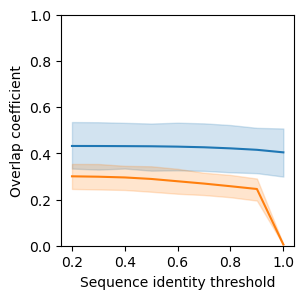

In [5]:
plt.figure(figsize=(3, 3))
sns.lineplot(data=coefs.reset_index(), 
             y='Overlap coefficient', x='Identity')
sns.lineplot(data=coefs_rand.reset_index(), 
             y='Overlap coefficient', x='Identity', color=sns.color_palette()[1])
plt.xlabel('Sequence identity threshold')
plt.ylim(0,1)
plt.savefig('../figs/overlap_coefs_ident.pdf')

##### Heatmap and clustering

In [2]:
coefs = pd.read_pickle('../data/overlap_coefs.pkl.gz')
coefs_rand = pd.read_pickle('../data/overlap_coefs_rand.pkl.gz')

dbs = ['BIOGRID','DIP','IntAct','mentha','MINT','signor','BioPlex','STRING']

*com, = combinations(dbs, 2)
coefs['Contrast'] = com*9

In [3]:
cvs9 = pd.merge(coefs[coefs.Identity==0.9], coefs[coefs.Identity==1], on='Contrast')
cvs9['Delta overlap coefficient'] = cvs9['Overlap coefficient_x']-cvs9['Overlap coefficient_y']

cvs8 = pd.merge(coefs[coefs.Identity==0.8], coefs[coefs.Identity==1], on='Contrast')
cvs8['Delta overlap coefficient'] = cvs8['Overlap coefficient_x']-cvs8['Overlap coefficient_y']

cvs = pd.concat([cvs8,cvs9])

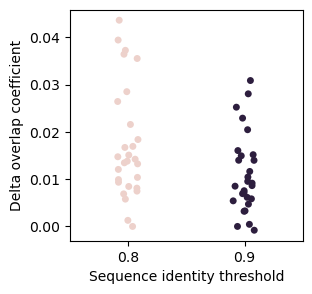

In [4]:
plt.figure(figsize=(3, 3))
sns.stripplot(data=cvs, x='Identity_x', y='Delta overlap coefficient', 
              hue='Identity_x', legend=None)
plt.xlabel('Sequence identity threshold')
plt.savefig('../figs/overlap_coefs_delta.pdf', bbox_inches='tight')

In [5]:
cvs.sort_values('Delta overlap coefficient')

Overlap coefficient_x  Identity_x            Contrast  \
18               0.797453         0.9      (mentha, MINT)   
14               1.000000         0.8      (IntAct, MINT)   
14               1.000000         0.9      (IntAct, MINT)   
25               0.011716         0.9   (signor, BioPlex)   
25               0.012560         0.8   (signor, BioPlex)   
11               0.026959         0.9      (DIP, BioPlex)   
23               0.066444         0.9     (MINT, BioPlex)   
2                0.776167         0.9   (BIOGRID, mentha)   
5                0.329702         0.9  (BIOGRID, BioPlex)   
11               0.029527         0.8      (DIP, BioPlex)   
4                0.226128         0.9   (BIOGRID, signor)   
3                0.208922         0.9     (BIOGRID, MINT)   
6                0.601529         0.8   (BIOGRID, STRING)   
10               0.060999         0.9       (DIP, signor)   
20               0.617673         0.9   (mentha, BioPlex)   
2                0.778924         0.8   (BIOGRID, mentha)   
22               0.081869         0.9      (MINT, signor)   
5                0.332390         0.8  (BIOGRID, BioPlex)   
23               0.071611         0.8     (MINT, BioPlex)   
24               0.356769         0.9      (MINT, STRING)   
6                0.603277         0.9   (BIOGRID, STRING)   
9                0.108303         0.9         (DIP, MINT)   
20               0.619869         0.8   (mentha, BioPlex)   
27               0.581387         0.9   (BioPlex, STRING)   
24               0.358164         0.8      (MINT, STRING)   
3                0.213139         0.8     (BIOGRID, MINT)   
13               0.748105         0.9    (IntAct, mentha)   
16               0.605896         0.9   (IntAct, BioPlex)   
10               0.066127         0.8       (DIP, signor)   
27               0.585098         0.8   (BioPlex, STRING)   
9                0.112605         0.8         (DIP, MINT)   
4                0.234092         0.8   (BIOGRID, signor)   
0                0.138307         0.9      (BIOGRID, DIP)   
19               0.350176         0.9    (mentha, signor)   
16               0.608486         0.8   (IntAct, BioPlex)   
22               0.089052         0.8      (MINT, signor)   
7                0.806700         0.9       (DIP, IntAct)   
7                0.806856         0.8       (DIP, IntAct)   
1                0.509232         0.9   (BIOGRID, IntAct)   
26               0.374414         0.9    (signor, STRING)   
18               0.814963         0.8      (mentha, MINT)   
13               0.754594         0.8    (IntAct, mentha)   
0                0.142708         0.8      (BIOGRID, DIP)   
15               0.220855         0.9    (IntAct, signor)   
1                0.515625         0.8   (BIOGRID, IntAct)   
12               0.386108         0.9       (DIP, STRING)   
8                0.821414         0.9       (DIP, mentha)   
12               0.389629         0.8       (DIP, STRING)   
21               0.463266         0.9    (mentha, STRING)   
19               0.364682         0.8    (mentha, signor)   
17               0.347835         0.9    (IntAct, STRING)   
26               0.393887         0.8    (signor, STRING)   
8                0.832617         0.8       (DIP, mentha)   
15               0.237648         0.8    (IntAct, signor)   
21               0.474640         0.8    (mentha, STRING)   
17               0.360589         0.8    (IntAct, STRING)   

    Overlap coefficient_y  Identity_y  Delta overlap coefficient  
18               0.798255         1.0                  -0.000802  
14               1.000000         1.0                   0.000000  
14               1.000000         1.0                   0.000000  
25               0.011273         1.0                   0.000443  
25               0.011273         1.0                   0.001287  
11               0.023752         1.0                   0.003207  
23               0.063158         1.0                   0

In [6]:
m = coefs[coefs.Identity==1].copy()
m['DB1'] = m.Contrast.apply(lambda x: x[0])
m['DB2'] = m.Contrast.apply(lambda x: x[1])
m = pd.concat([pd.DataFrame({'Overlap coefficient':1,'DB1':dbs,'DB2':dbs}),
               m[['Overlap coefficient','DB1','DB2']],
               m[['Overlap coefficient','DB1','DB2']].\
               rename(columns={'Overlap coefficient':'Overlap coefficient',
                               'DB1':'DB2','DB2':'DB1'})])
m = pd.pivot_table(m, values="Overlap coefficient", index=['DB1'], columns=['DB2'])

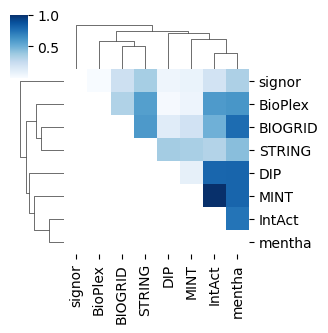

In [7]:
g = sns.clustermap(m, cmap="Blues", figsize=(3.5,3.5))
mask = np.tril(np.ones_like(m))
values = g.ax_heatmap.collections[0].get_array().reshape(m.shape)
new_values = np.ma.array(values, mask=mask)
g.ax_heatmap.collections[0].set_array(new_values)
g.ax_heatmap.set(xlabel=None, ylabel=None)

plt.savefig('../figs/overlap_coefs_heatmap_tri.pdf')

In [ ]:
# coefs[coefs.Identity==1]['Overlap coefficient'].describe()

#### Plot PPI networks

In [1]:
import requests
import pandas as pd
from io import StringIO 
from bs4 import BeautifulSoup

In [3]:
pdb_ppi = pd.read_pickle('../data/pdb_ppi.pkl.gz')
ogid = pdb_ppi['OrthoDB pairs'].str.split('_').apply(lambda x: x[0]).tolist() \
+ pdb_ppi['OrthoDB pairs'].str.split('_').apply(lambda x: x[1]).tolist()
ogid = set(ogid)
len(ogid)

9105

In [12]:
ogname = []
for i in list(ogid)[283:]:
    res = requests.get('https://data.orthodb.org/current/tab?id=' + i)
    d = pd.DataFrame(StringIO(res.content.decode("utf-8")))
    try:
        d['orthodb'] = d[0].str.split('\t')
        og = d.orthodb.apply(lambda x: x[1]).iloc[1]
    except IndexError:
        pass
    ogname.append([i,og])
    
ogname = pd.DataFrame(ogname)
ogname.columns = ['OrthoDB','Ortholog group name']
ogname.to_pickle('../data/ogname.pkl.gz')

In [2]:
ogname = pd.read_pickle('../data/ogname.pkl.gz')
pdb_ppi = pd.read_pickle('../data/pdb_ppi.pkl.gz')

pdb_ppi['OrthoDB'] = pdb_ppi['OrthoDB pairs'].str.split('_').apply(lambda x: x[0])
og = pd.merge(ogname, pdb_ppi).rename(columns={'OrthoDB':'OrthoDB 1','Ortholog group name':'OG 1'})
og['OrthoDB'] = og['OrthoDB pairs'].str.split('_').apply(lambda x: x[1])
og = pd.merge(ogname, og).rename(columns={'OrthoDB':'OrthoDB 2','Ortholog group name':'OG 2'})

ds = og[og.Solved==0].copy()
ds['weight'] = 1
du = og[og.Solved==1].copy()
du['weight'] = 10
df = pd.concat([ds,du])
df = df[df.Counts>=5][['OG 1','OG 2','weight']]
df.columns = [0, 'b', 'weight']

In [9]:
og[og['OG 1'].str.contains('Wnt')]

OrthoDB 2                                               OG 2  \
2565    2882052at2759    Fli-1 proto-oncogene, ETS transcription factor    
11012   5491123at2759                                          Ubiquilin   
13437   3016042at2759                     Wnt ligand secretion mediator    
13444   3016042at2759                     Wnt ligand secretion mediator    
13445   3016042at2759                     Wnt ligand secretion mediator    
29354   2879721at2759              discs large MAGUK scaffold protein 1    
33757   4136179at2759                 cholinergic receptor muscarinic 2    
39552   5317371at2759           lysosomal associated membrane protein 2    
41773   5475408at2759           delta like non-canonical Notch ligand 1    
51687   3918101at2759                  low density lipoprotein receptor    
56589   4604454at2759                C-C chemokine receptor type 5-like    
58067   2967820at2759       phosphoinositide-3-kinase adaptor protein 1    
58913   5348983at2759                         transmembrane protein 14A    
66070   5403755at2759     PAS domain containing serine/threonine kinase    
70364    354414at2759  latent transforming growth factor beta binding...   
76994      8685at2759  dexamethasone-induced Ras-related protein 1-like    
81326   2910598at2759               Segment polarity protein dishevelled   
87069   5483535at2759                                           Frizzled   
102978  2874082at2759                                                Wnt   
114048  3236018at2759                  aquaporin 1 (Colton blood group)    
124246  4215044at2759             ER membrane protein complex subunit 7    
124455    48111at2759                             lysine demethylase 4A    
127402  5397373at2759                        galectin 3 binding protein    
143746  5489154at2759                                       Calreticulin   
149266  4554405at2759     translocase of outer mitochondrial membrane 6    
157586  4253584at2759              Histone-lysine N-methyltransferase 2C   
160788  5196468at2759                                 alpha fetoprotein    
176591   720228at2759      notum, palmitoleoyl-protein carboxylesterase    
186904  3035117at2759                              Lysyl oxidase homolog   
191302   314723at2759        heterogeneous nuclear ribonucleoprotein H3    
191875  5393360at2759                   delta-type opioid receptor-like    
193993  3683708at2759                    sclerostin domain containing 1    
197096    35876at2759                               Alkaline phosphatase   
201832  5473951at2759  protein phosphatase 2 regulatory subunit B'alpha    
203392  3028121at2759                        ligand of numb-protein X 2    
204938  2913784at2759             TNF receptor-associated factor 2-like    
205664  4219076at2759                sprouty RTK signaling antagonist 1    
215666  4649019at2759                                            Tubulin   
228074  3124041at2759                           tubulin beta 1 class VI    
229363  2957548at2759                       porcupine O-acyltransferase    
230342  3107655at2759   Low-density lipoprotein receptor-related protein   
263995  4329885at2759        dickkopf WNT signaling pathway inhibitor 2    
269009  5490637at2759                      RING finger protein 151-like    
270536  4219275at2759                         neuronal pentraxin-1-like    

            OrthoDB 1                            OG 1  \
2565    2874082at2759                             Wnt   
11012   2874082at2759                             Wnt   
13437   3016042at2759  Wnt ligand secretion mediator    
13444   2874082at2759                             Wnt   
13445   2874082at2759                             Wnt   
29354   2874082at2759                             Wnt   
33757   3016042at2759  Wnt ligand secretion mediator    
39552   2874082at2759                             Wnt   
41773   2874082at2759                             Wnt   
51687   2874082at2759

In [10]:
og[og['OG 2'].str.contains('Wnt')]

OrthoDB 2                            OG 2      OrthoDB 1  \
13437   3016042at2759  Wnt ligand secretion mediator   3016042at2759   
13438   3016042at2759  Wnt ligand secretion mediator   1453907at2759   
13439   3016042at2759  Wnt ligand secretion mediator   2909020at2759   
13440   3016042at2759  Wnt ligand secretion mediator   2881452at2759   
13441   3016042at2759  Wnt ligand secretion mediator   1331921at2759   
13442   3016042at2759  Wnt ligand secretion mediator   2999405at2759   
13443   3016042at2759  Wnt ligand secretion mediator   2902801at2759   
13444   3016042at2759  Wnt ligand secretion mediator   2874082at2759   
13445   3016042at2759  Wnt ligand secretion mediator   2874082at2759   
13446   3016042at2759  Wnt ligand secretion mediator   2897965at2759   
13447   3016042at2759  Wnt ligand secretion mediator   1360344at2759   
13448   3016042at2759  Wnt ligand secretion mediator   2905973at2759   
13449   3016042at2759  Wnt ligand secretion mediator   2996449at2759   
13450   3016042at2759  Wnt ligand secretion mediator     21687at2759   
13451   3016042at2759  Wnt ligand secretion mediator    168438at2759   
13452   3016042at2759  Wnt ligand secretion mediator   1330770at2759   
13453   3016042at2759  Wnt ligand secretion mediator   2902735at2759   
102973  2874082at2759                             Wnt    10768at2759   
102974  2874082at2759                             Wnt  1614410at2759   
102975  2874082at2759                             Wnt    19833at2759   
102976  2874082at2759                             Wnt   158564at2759   
102977  2874082at2759                             Wnt      143at2759   
102978  2874082at2759                             Wnt  2874082at2759   
102979  2874082at2759                             Wnt    25995at2759   
102980  2874082at2759                             Wnt  1063832at2759   
102981  2874082at2759                             Wnt  1220028at2759   
102982  2874082at2759                             Wnt  2873736at2759   

                                                     OG 1  \
13437                      Wnt ligand secretion mediator    
13438   cyclase associated actin cytoskeleton regulato...   
13439                             adenosine A2a receptor    
13440              C-type lectin domain family 4 member A   
13441                    EBP cholestenol delta-isomerase    
13442                        5-hydroxytryptamine receptor   
13443                    SRY-box transcription factor 10    
13444                                                 Wnt   
13445                                                 Wnt   
13446                  voltage dependent anion channel 1    
13447    cysteine and histidine rich domain containing 1    
13448   calcium release-activated calcium channel prot...   
13449   FCH and mu domain containing endocytic adaptor 2    
13450                        nuclear RNA export factor 1    
13451                spermatogenesis associated 5 like 1    
13452                                          nicastrin    
13453                smoothened, frizzled class receptor    
102973    cAMP-dependent protein kinase catalytic subunit   
102974  ABL proto-oncogene 1, non-receptor tyrosine ki...   
102975                                        phosphatase   
102976                   Mitogen-activated protein kinase   
102977                                              hsp70   
102978                                                Wnt   
102979              capping actin protein, gelsolin like    
102980                                   fem-1 homolog C    
102981                   exostosin glycosyltransferase 1    
102982                                            Caspase   

                      OrthoDB pairs  Counts  \
13437   3016042at2759_3016042at2759       1   
13438   1453907at2759_3016042at2759       1   
13439   2909020at2759_3016042at2759       1   
13440   2881452at2759_3016042at2759       1   
13441   1331921at2759_3016042at2759       1   
1344

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from netgraph import Graph, InteractiveGraph, EditableGraph
import itertools

G = nx.from_pandas_edgelist(df, 0, 'b', 'weight')
G.remove_edges_from(nx.selfloop_edges(G))
# nx.write_gexf(G, 'unsolved_3.gexf')
# nx.write_graphml(G, 'unsolved_3.graphml')

subs = sorted(nx.connected_components(G), key=len)[:-10]
G.remove_nodes_from(itertools.chain.from_iterable(subs))
pos = nx.spring_layout(G, seed=47)
nx.is_weighted(G)

True

/Volumes/scratch/limlab/anaconda3/lib/python3.11/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


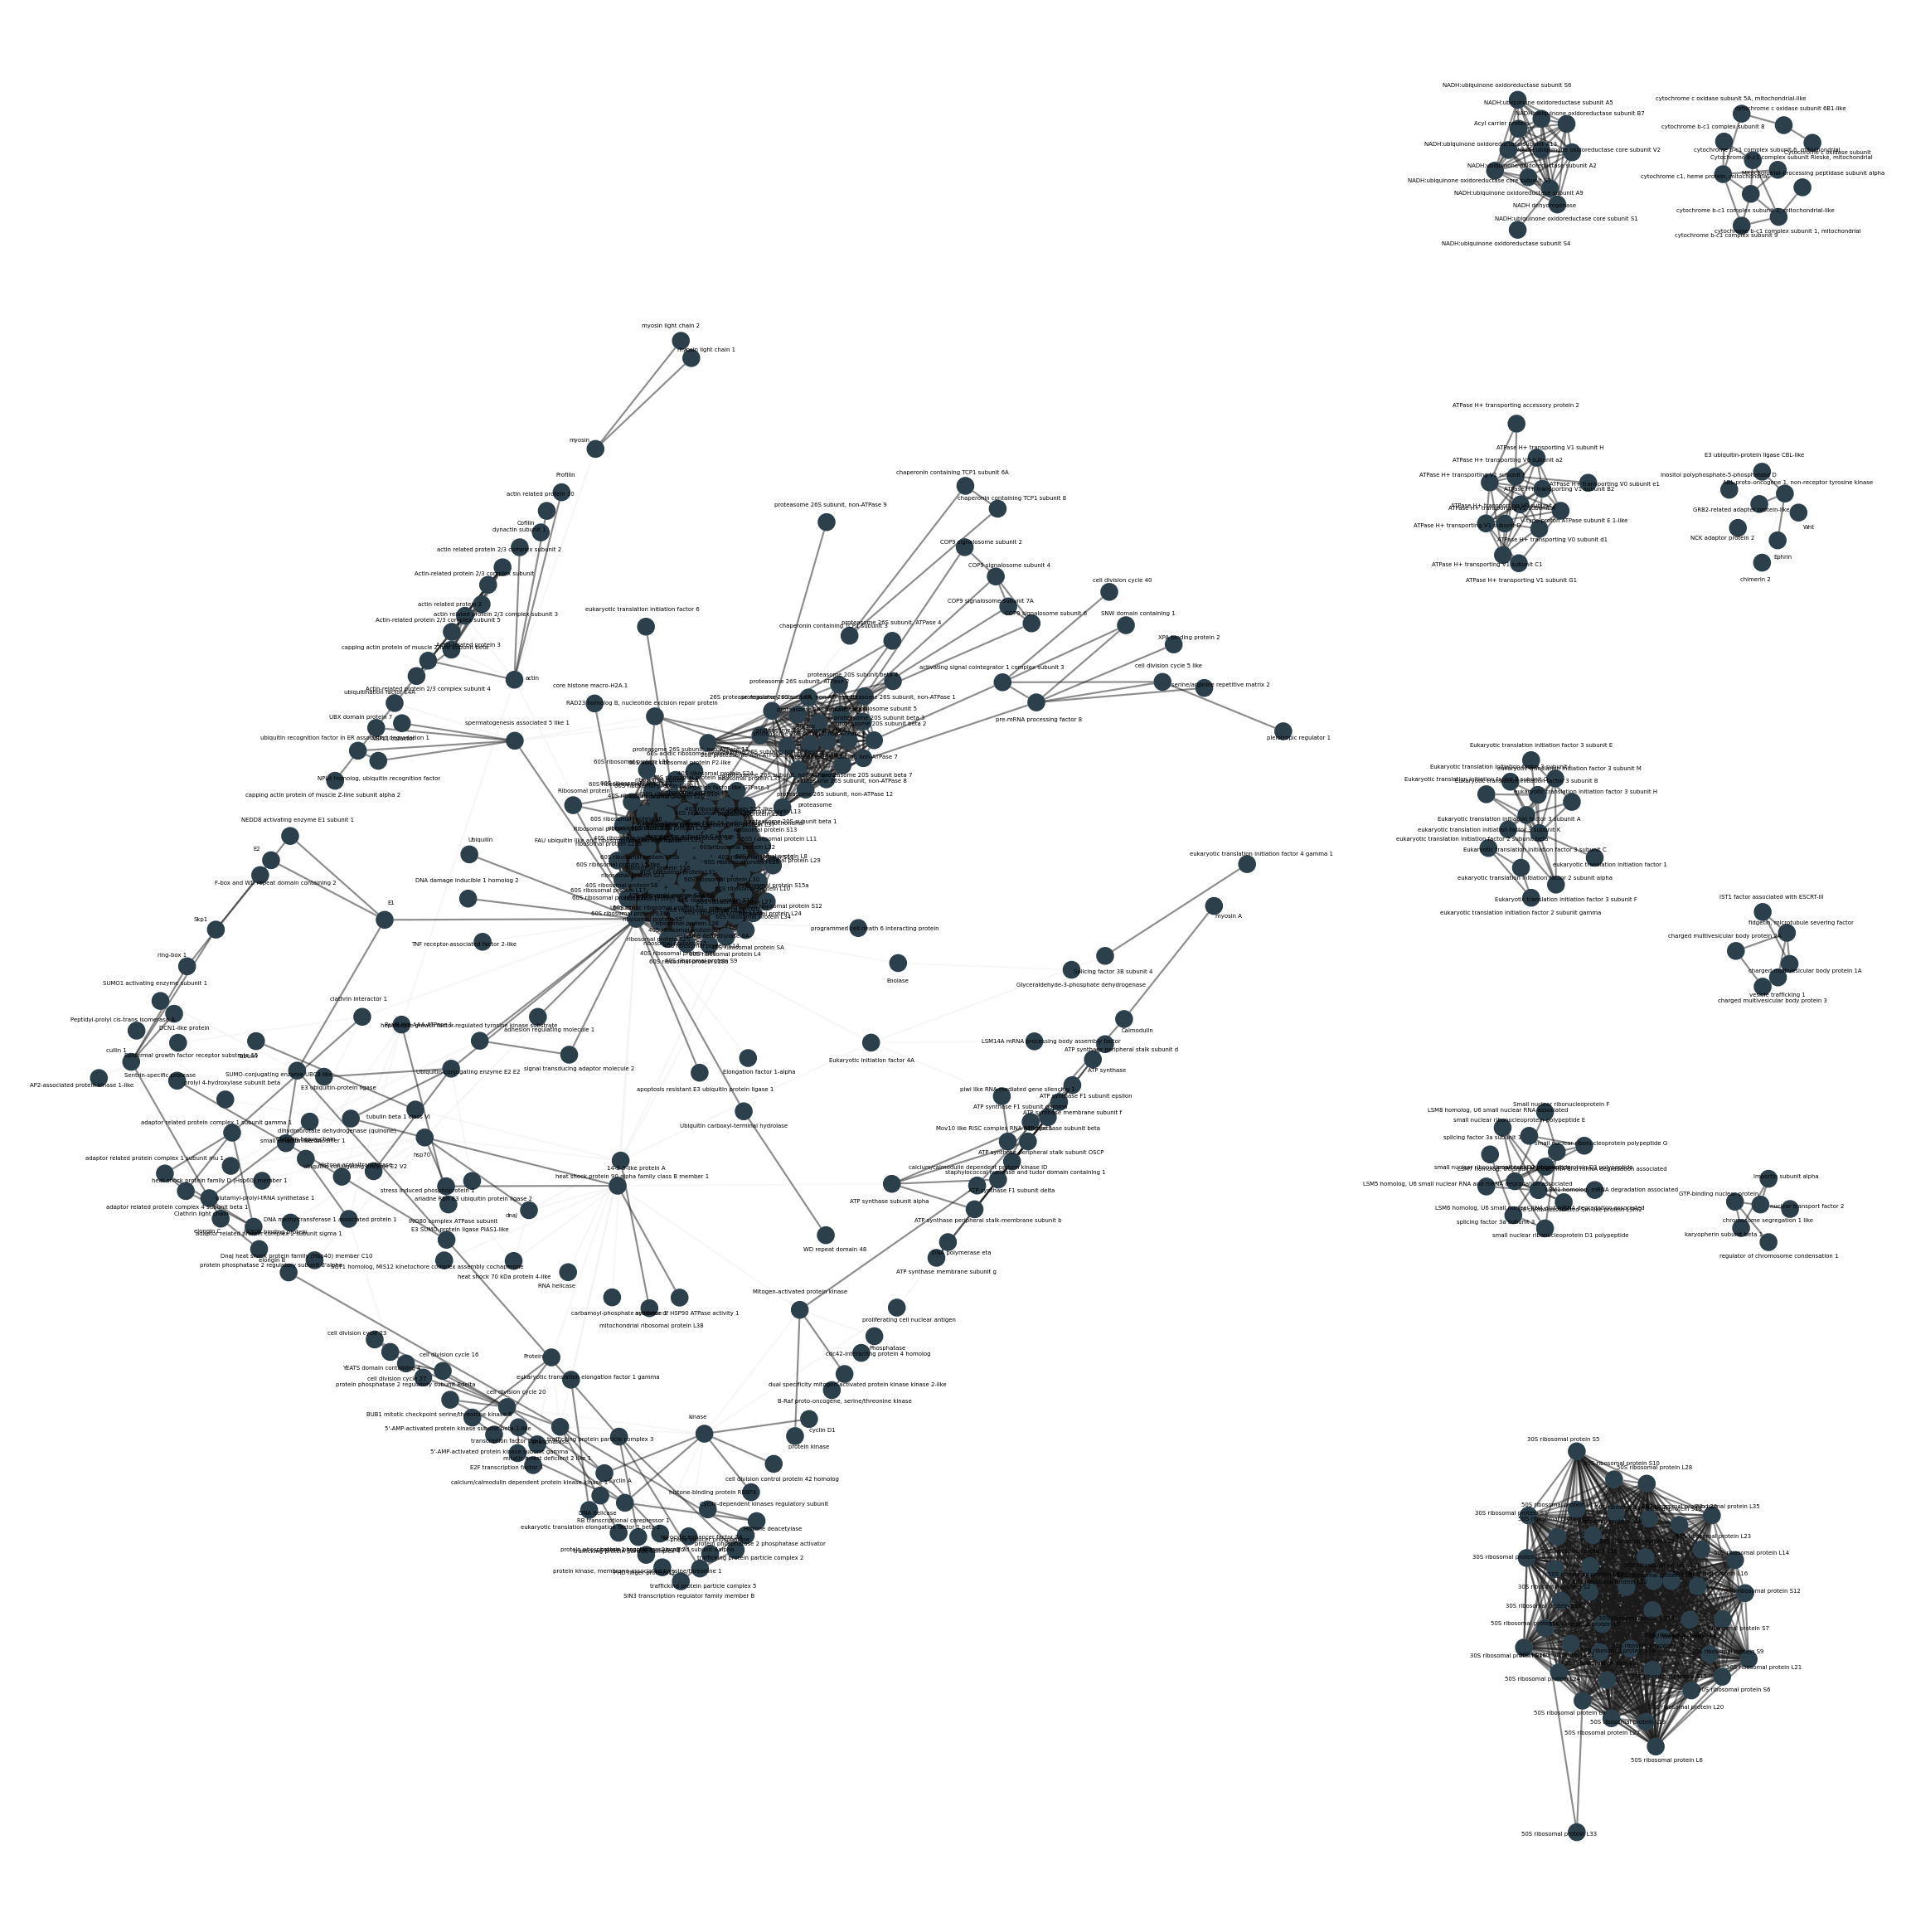

In [4]:
plt.figure(figsize=(30,30))

plot_instance = Graph(
    G, node_size=0.5, shape=(2, 2),
    node_labels=True, node_label_offset=0.01, 
    node_label_fontdict=dict(size=5), edge_width=0.1)

plt.savefig('../figs/networks_og.pdf')